# Lab 1 Report: SDR Sampling, Spectra, Noise, and Mixers

**Author:** <Your Name>  
**Date:** <YYYY-MM-DD>  
**Course:** <Course + Section>  
**Manual Baseline:** `lab_mixers/allmixers.tex`  
**Package/Repo:** `<link or local path to installable package>`


In [22]:
# SIM_RUNNER: Global setup for experiment simulation figures (E1-E7)
from __future__ import annotations

import sys
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from IPython.display import display


def _resolve_lab_dir() -> Path:
    cwd = Path.cwd()
    if (cwd / "src" / "ugradio_lab1").exists():
        return cwd
    if (cwd / "labs" / "01" / "src" / "ugradio_lab1").exists():
        return cwd / "labs" / "01"
    raise RuntimeError("Could not locate labs/01 from current working directory.")


LAB_DIR = _resolve_lab_dir()
SRC_DIR = LAB_DIR / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from ugradio_lab1.analysis.noise import radiometer_fit
from ugradio_lab1.analysis.spectra import power_spectrum, voltage_spectrum
from ugradio_lab1.plotting.figure_builders import (
    ACFSpectrumConsistencyFigureBuilder,
    AliasMapFigureBuilder,
    BandpassFigureBuilder,
    ComplexVoltageComponentsFigureBuilder,
    DSBOutputSpectrumFigureBuilder,
    FilteredWaveformFigureBuilder,
    LeakageComparisonFigureBuilder,
    MultiWindowSpectrumFigureBuilder,
    NoiseHistogramFigureBuilder,
    R820TComparisonFigureBuilder,
    RadiometerFigureBuilder,
    ResolutionFigureBuilder,
    RevertedDSBComparisonFigureBuilder,
    SSBIQBehaviorFigureBuilder,
    SpurSurveyFigureBuilder,
    TimeDomainComparisonFigureBuilder,
    VoltagePowerComparisonFigureBuilder,
)
from ugradio_lab1.plotting.style import apply_lab_style
from ugradio_lab1.pipeline.e1 import (
    DEFAULT_E1_F2_FIGURE_PATH,
    DEFAULT_E1_QC_CATALOG_PATH,
    DEFAULT_E1_RAW_SOURCE,
    DEFAULT_E1_RUN_CATALOG_PATH,
    DEFAULT_E1_T2_TABLE_PATH,
    DEFAULT_E1_T3_TABLE_PATH,
    build_e1_qc_catalog,
    build_e1_run_catalog,
    build_e1_t2_table,
    build_e1_t3_table,
    write_dataframe_csv,
    write_e1_alias_figure,
    write_table_manifest_csv,
)
from ugradio_lab1.pipeline.e2 import (
    DEFAULT_E2_CURVE_TABLE_PATH,
    DEFAULT_E2_F4_FIGURE_PATH,
    DEFAULT_E2_QC_CATALOG_PATH,
    DEFAULT_E2_RAW_SOURCE,
    DEFAULT_E2_RUN_CATALOG_PATH,
    DEFAULT_E2_T2_TABLE_PATH,
    DEFAULT_E2_T4_TABLE_PATH,
    build_e2_bandpass_curve_table,
    build_e2_qc_catalog,
    build_e2_run_catalog,
    build_e2_t2_table,
    build_e2_t4_table,
    write_e2_bandpass_figure,
)
from ugradio_lab1.pipeline.e3 import (
    DEFAULT_E3_F5_FIGURE_PATH,
    DEFAULT_E3_F6_FIGURE_PATH,
    DEFAULT_E3_QC_CATALOG_PATH,
    DEFAULT_E3_RAW_SOURCE,
    DEFAULT_E3_RUN_CATALOG_PATH,
    DEFAULT_E3_SPECTRUM_TABLE_PATH,
    DEFAULT_E3_T2_TABLE_PATH,
    build_e3_qc_catalog,
    build_e3_run_catalog,
    build_e3_spectrum_profile,
    build_e3_spectrum_profiles,
    build_e3_t2_table,
    write_e3_voltage_components_figure,
    write_e3_voltage_power_figure,
)
from ugradio_lab1.pipeline.e5 import (
    DEFAULT_E5_CURVE_TABLE_PATH,
    DEFAULT_E5_F10_FIGURE_PATH,
    DEFAULT_E5_F11_FIGURE_PATH,
    DEFAULT_E5_F12_FIGURE_PATH,
    DEFAULT_E5_QC_CATALOG_PATH,
    DEFAULT_E5_RAW_SOURCE,
    DEFAULT_E5_RUN_CATALOG_PATH,
    DEFAULT_E5_STATS_TABLE_PATH,
    DEFAULT_E5_T2_TABLE_PATH,
    DEFAULT_E5_T6_TABLE_PATH,
    build_e5_noise_stats_table,
    build_e5_qc_catalog,
    build_e5_radiometer_curve_table,
    build_e5_run_catalog,
    build_e5_t2_table,
    build_e5_t6_table,
    fit_e5_radiometer,
    select_e5_analysis_runs,
    write_e5_acf_consistency_figure,
    write_e5_noise_histogram_figure,
    write_e5_radiometer_figure,
)
from ugradio_lab1.sim.mixers import (
    simulate_dsb_spur_survey,
    simulate_r820t_vs_external,
    simulate_reverted_dsb_iq,
    simulate_ssb_iq,
)
from ugradio_lab1.sim.noise import (
    simulate_acf_consistency,
    simulate_noise_capture,
    simulate_radiometer_experiment,
)
from ugradio_lab1.sim.nyquist import (
    sample_times,
    simulate_alias_sweep,
    simulate_bandpass_sweep,
    simulate_leakage_experiment,
    simulate_multi_window_spectrum,
    simulate_resolution_sweep,
    generate_multi_tone,
)

apply_lab_style()

# Inline display mode by default.
SAVE_SIM_FIGURES = False
FIG_DIR = LAB_DIR / "report" / "figures"

SEED = 20260208
RNG = np.random.default_rng(SEED)
generated_figure_labels: list[str] = []
TIME_DOMAIN_SLICE = slice(0, 300)


def save_figure(fig, filename: str) -> Path | None:
    label = filename
    if SAVE_SIM_FIGURES:
        FIG_DIR.mkdir(parents=True, exist_ok=True)
        path = FIG_DIR / filename
        fig.savefig(path, dpi=180, bbox_inches="tight")
        display(fig)
        plt.close(fig)
        generated_figure_labels.append(str(path))
        return path

    display(fig)
    plt.close(fig)
    generated_figure_labels.append(label)
    return None


print(f"LAB_DIR: {LAB_DIR}")
print(f"SAVE_SIM_FIGURES={SAVE_SIM_FIGURES} (set True to write into {FIG_DIR})")
print(f"TIME_DOMAIN_SLICE={TIME_DOMAIN_SLICE} for readable time-domain plots")


LAB_DIR: /Users/junruiting/GitHub/ugradio/labs/01
SAVE_SIM_FIGURES=False (set True to write into /Users/junruiting/GitHub/ugradio/labs/01/report/figures)
TIME_DOMAIN_SLICE=slice(0, 300, None) for readable time-domain plots


## Abstract

Write this last (150-250 words).

- Context: one sentence on SDR sampling and mixer relevance.
- Aim: summarize the section-2 goals being tested.
- Methods: state physical experiments + simulations.
- Key quantitative outcomes: aliasing, bandpass behavior, leakage/resolution, noise/radiometer scaling, DSB/SSB behavior.
- Conclusion: what was validated, what failed, and confidence level.


## 1. Introduction

- Scientific context: why sampling, spectra, and heterodyne mixing matter.
- Scope: this report reproduces and tests the full content of `allmixers.tex`.
- Philosophy: "mistrust everything" with explicit diagnostics and controls.
- Report map: cite the experiment series and simulation cross-checks.


## 2. Goals and Traceability

| Goal (from manual section 2) | Experiment(s) | Primary Evidence |
| --- | --- | --- |
| Nyquist sampling and aliasing | E1 | Alias map, prediction residuals |
| SDR bandpass characterization | E2 | Gain-vs-frequency curves (default/FIR modes) |
| Power and voltage spectra usage | E3 | Complex voltage + power spectrum consistency checks |
| Spectral leakage and frequency resolution | E4 | Leakage profiles, two-tone separability vs sample count |
| Noise properties and radiometer equation | E5 | Histogram Gaussianity, variance scaling with averaging |
| DSB/SSB mixer operation and importance | E6-E7 | Sideband behavior, IQ phase, intermod products |
| Quantitative rigor and diagnostics | All | Calibration logs, residuals, uncertainty statements |
| Installable package + tests | Repro Appendix | Package structure, unit test summary, repo link |


## 3. Theory and Modeling Framework

Include only equations directly used in analysis.

1. Sampling and aliasing relations.
2. Discrete Fourier transform conventions and units.
3. Voltage spectrum vs power spectrum definitions.
4. Leakage from finite-time windows (Convolution Theorem intuition).
5. ACF-power spectrum relationship (Correlation Theorem).
6. Mixer equations for DSB and SSB, including LO/RF sideband interpretation.
7. Noise statistics and radiometer-equation scaling.

Add a short table that defines every symbol used in figures/tables.


<!-- THEORY_FRAMEWORK:OVERVIEW -->
This section establishes the mathematical model used across all experiments (E1-E7): deterministic waves and superposition, sampling/aliasing structure, Fourier-domain analysis, DFT/FFT computation, and frequency-domain filtering/mixing relationships. The same framework underlies both the simulation pipeline and the physical SDR/mixer measurements.

We use these conventions throughout:
- Continuous-time variable: $t$ (seconds), frequency: $f$ (Hz)
- Sampling period: $T_s = 1/f_s$, sampled index: $n \in \{0,\dots,N-1\}$
- Complex exponential convention: $e^{j2\pi f t}$
- Discrete Fourier transform (unnormalized forward transform):
  $$X[k] = \sum_{n=0}^{N-1} x[n]e^{-j2\pi kn/N}$$


<!-- THEORY_FRAMEWORK:SYMBOL_TABLE -->
#### Symbol Table

| Symbol | Meaning | Units |
| --- | --- | --- |
| $t$ | Continuous-time variable | s |
| $n$ | Discrete sample index | unitless |
| $f$ | Continuous frequency | Hz |
| $f_s$ | Sampling rate | Hz |
| $T_s$ | Sampling period ($1/f_s$) | s |
| $N$ | Number of samples in a record | samples |
| $x(t),x[n]$ | Time-domain voltage signal (continuous/discrete) | V (or arb) |
| $X(f),X[k]$ | Fourier-domain representation (continuous/discrete) | V·s / complex arb |
| $P[k]$ | Per-bin power estimate | V$^2$ (or arb) |
| $h(t),h[n]$ | Filter impulse response (continuous/discrete) | unitless |
| $H(f),H(e^{j\omega})$ | Filter frequency response | unitless |
| $f_{RF}, f_{LO}, f_{IF}$ | RF, local oscillator, and intermediate frequencies | Hz |


<!-- THEORY_FRAMEWORK:WAVES -->
### 3.1 Waves and Superposition

A sinusoidal voltage waveform is modeled as
$$x(t)=A\cos(2\pi f_0 t + \phi).$$
Using complex notation,
$$x(t)=\Re\{\tilde A e^{j2\pi f_0 t}\}, \qquad \tilde A = A e^{j\phi}.$$

If two waves propagate in a linear system, the total response is additive:
$$x(t)=x_1(t)+x_2(t).$$
For equal-amplitude nearby tones (same phase for simplicity),
$$\cos(2\pi f_1 t)+\cos(2\pi f_2 t)
=2\cos\!\left(2\pi\frac{f_1-f_2}{2}t\right)
\cos\!\left(2\pi\frac{f_1+f_2}{2}t\right),$$
which gives an envelope (beat) at $|f_1-f_2|$ around a carrier near $(f_1+f_2)/2$. This is directly relevant to heterodyne beat-note interpretation in mixer experiments.


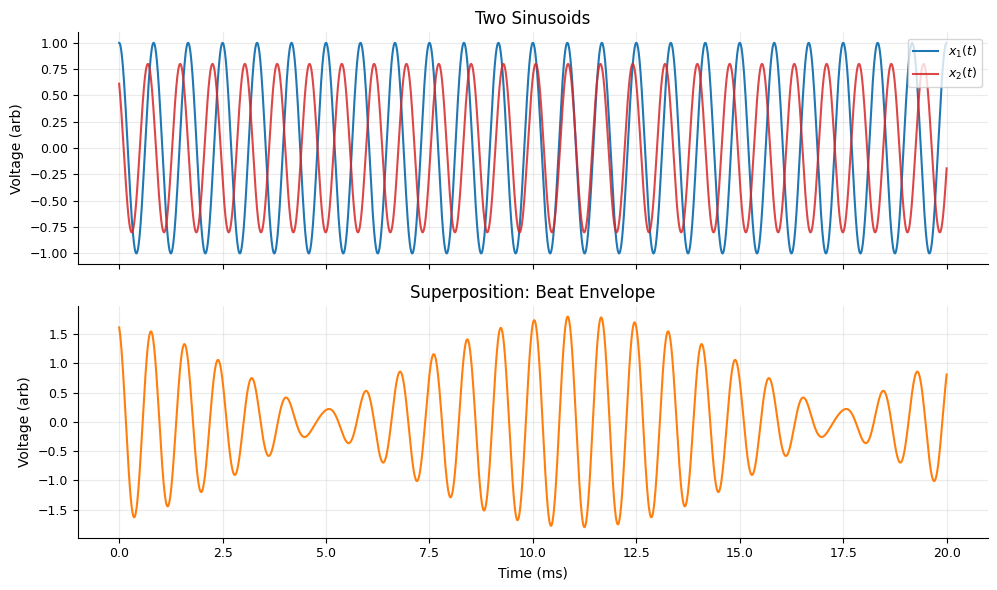

In [23]:
# THEORY_DEMO: Waves and superposition (beats)
f1_hz, f2_hz = 1200.0, 1280.0
t_s = np.linspace(0.0, 0.02, 4000)
x1 = np.cos(2.0 * np.pi * f1_hz * t_s)
x2 = 0.8 * np.cos(2.0 * np.pi * f2_hz * t_s + 0.7)
x_sum = x1 + x2

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axes[0].plot(t_s * 1e3, x1, label=r"$x_1(t)$")
axes[0].plot(t_s * 1e3, x2, label=r"$x_2(t)$", alpha=0.85)
axes[0].set_ylabel("Voltage (arb)")
axes[0].set_title("Two Sinusoids")
axes[0].legend(loc="upper right")
axes[0].grid(True, alpha=0.25)

axes[1].plot(t_s * 1e3, x_sum, color="C3")
axes[1].set_xlabel("Time (ms)")
axes[1].set_ylabel("Voltage (arb)")
axes[1].set_title("Superposition: Beat Envelope")
axes[1].grid(True, alpha=0.25)

fig.tight_layout()
plt.show()

<!-- THEORY_FRAMEWORK:SAMPLING -->
### 3.2 Digital Sampling, Aliasing, Nyquist Frequency, and Nyquist Zones

Sampling maps a continuous-time signal to a sequence:
$$x[n] = x_c(nT_s), \qquad T_s = 1/f_s.$$
For a tone $x_c(t)=Ae^{j2\pi f_0 t}$,
$$x[n]=Ae^{j2\pi (f_0/f_s)n}.$$
Because discrete-time frequency is $2\pi$-periodic, $f_0$ and $f_0 + m f_s$ are indistinguishable in sampled data ($m\in\mathbb{Z}$). This is aliasing.

The principal Nyquist interval is $[-f_s/2, f_s/2)$, and one convenient alias map is
$$f_{\text{alias}} = \left((f_{\text{true}}+f_s/2)\bmod f_s\right)-f_s/2.$$

Nyquist frequency: $f_N=f_s/2$. Frequencies outside the principal interval fold into this interval, producing zone-dependent sign/placement changes. This is the core mechanism analyzed in E1.


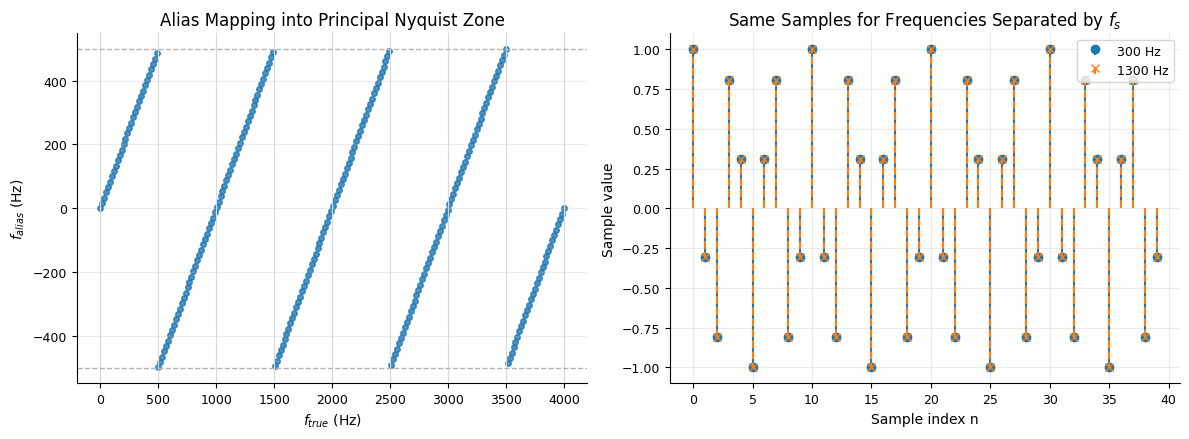

In [24]:
# THEORY_DEMO: Aliasing map and sample-level ambiguity
fs_hz = 1000.0
f_true_hz = np.linspace(0.0, 4000.0, 240)
f_alias_hz = np.mod(f_true_hz + fs_hz / 2.0, fs_hz) - fs_hz / 2.0

n = np.arange(40)
f_low_hz, f_high_hz = 300.0, 1300.0  # differ by fs
x_low = np.cos(2.0 * np.pi * f_low_hz * n / fs_hz)
x_high = np.cos(2.0 * np.pi * f_high_hz * n / fs_hz)

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
axes[0].scatter(f_true_hz, f_alias_hz, s=16, alpha=0.8)
for boundary in np.arange(0.0, 4000.0 + fs_hz / 2.0, fs_hz / 2.0):
    axes[0].axvline(boundary, color="0.85", linewidth=0.8)
axes[0].axhline(fs_hz / 2.0, color="0.7", linestyle="--", linewidth=1.0)
axes[0].axhline(-fs_hz / 2.0, color="0.7", linestyle="--", linewidth=1.0)
axes[0].set_xlabel(r"$f_{true}$ (Hz)")
axes[0].set_ylabel(r"$f_{alias}$ (Hz)")
axes[0].set_title("Alias Mapping into Principal Nyquist Zone")
axes[0].grid(True, alpha=0.25)

axes[1].stem(n, x_low, linefmt="C0-", markerfmt="C0o", basefmt=" ", label="300 Hz")
axes[1].stem(n, x_high, linefmt="C3--", markerfmt="C3x", basefmt=" ", label="1300 Hz")
axes[1].set_xlabel("Sample index n")
axes[1].set_ylabel("Sample value")
axes[1].set_title("Same Samples for Frequencies Separated by $f_s$")
axes[1].legend(loc="upper right")
axes[1].grid(True, alpha=0.25)

fig.tight_layout()
plt.show()

<!-- THEORY_FRAMEWORK:FOURIER_MATH -->
### 3.3 Fourier Analysis

#### 3.3a Mathematical definitions and energy relations
The continuous-time Fourier transform (CTFT) pair is
$$X(f)=\int_{-\infty}^{\infty}x(t)e^{-j2\pi ft}\,dt,
\qquad
x(t)=\int_{-\infty}^{\infty}X(f)e^{j2\pi ft}\,df.$$

Parseval's theorem (continuous form):
$$\int_{-\infty}^{\infty}|x(t)|^2dt = \int_{-\infty}^{\infty}|X(f)|^2df.$$
So total signal energy is invariant under transform-domain representation.

For a finite sampled record, with DFT as defined above, the discrete Parseval relation becomes
$$\sum_{n=0}^{N-1}|x[n]|^2 = \frac{1}{N}\sum_{k=0}^{N-1}|X[k]|^2.$$
Dividing by $N$ yields mean-square voltage:
$$\frac{1}{N}\sum_n |x[n]|^2 = \sum_k \frac{|X[k]|^2}{N^2}.$$


<!-- THEORY_FRAMEWORK:FOURIER_APP -->
#### 3.3b Practical spectral quantities in this lab
- **Voltage spectrum** (complex): amplitude/phase versus frequency, preserving sign and phase information needed for IQ and mixer interpretation.
- **Power spectrum**: non-negative per-bin power estimate,
  $$P[k]=\frac{|X[k]|^2}{N^2}$$
  (with this normalization), enabling energy accounting and line-strength comparison.
- **Power spectral density (PSD)**: power per Hz (when dividing by resolution bandwidth $\Delta f=f_s/N$).

In practice, E3 uses voltage and power spectra jointly, E5 uses power/ACF consistency, and E6-E7 use spectral line placement to identify mixing products/spurs.


Parseval time-domain mean-square: 9.650000e-01
Parseval freq-domain sum power : 9.650000e-01
Relative error                 : 1.150e-16


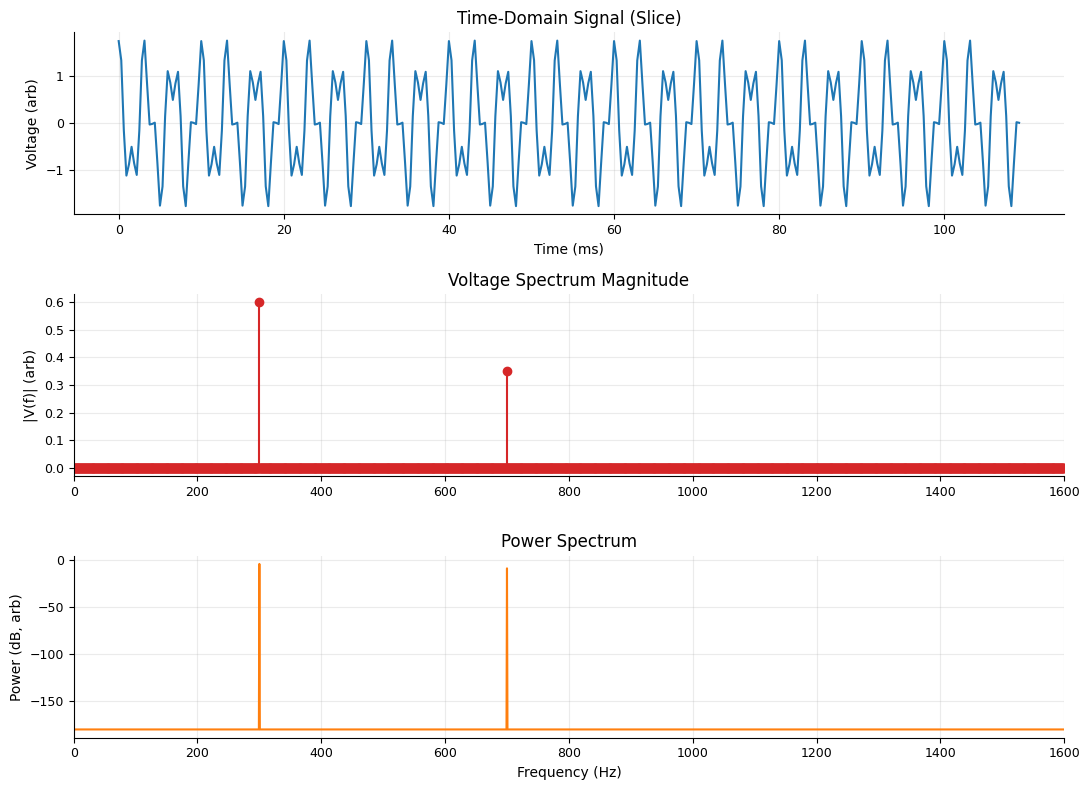

In [25]:
# THEORY_DEMO: Fourier decomposition, voltage spectrum, power spectrum, Parseval check
fs_hz = 3200.0
n_samples = 4096
t_s = np.arange(n_samples) / fs_hz
x = (
    1.20 * np.cos(2.0 * np.pi * 300.0 * t_s + 0.2)
    + 0.70 * np.cos(2.0 * np.pi * 700.0 * t_s - 0.6)
)

X = np.fft.fft(x)
f_hz = np.fft.fftfreq(n_samples, d=1.0 / fs_hz)
voltage_amp = np.abs(X) / n_samples
power_bin = (np.abs(X) ** 2) / (n_samples**2)

parseval_time = np.mean(x**2)
parseval_freq = np.sum(power_bin)
rel_err = abs(parseval_time - parseval_freq) / max(parseval_time, 1e-15)
print(f"Parseval time-domain mean-square: {parseval_time:.6e}")
print(f"Parseval freq-domain sum power : {parseval_freq:.6e}")
print(f"Relative error                 : {rel_err:.3e}")

mask = f_hz >= 0.0
fig, axes = plt.subplots(3, 1, figsize=(11, 8), sharex=False)

axes[0].plot(t_s[:350] * 1e3, x[:350], color="C0")
axes[0].set_xlabel("Time (ms)")
axes[0].set_ylabel("Voltage (arb)")
axes[0].set_title("Time-Domain Signal (Slice)")
axes[0].grid(True, alpha=0.25)

axes[1].stem(f_hz[mask], voltage_amp[mask], linefmt="C1-", markerfmt="C1o", basefmt=" ")
axes[1].set_xlim(0.0, fs_hz / 2.0)
axes[1].set_ylabel("|V(f)| (arb)")
axes[1].set_title("Voltage Spectrum Magnitude")
axes[1].grid(True, alpha=0.25)

axes[2].plot(f_hz[mask], 10.0 * np.log10(np.maximum(power_bin[mask], 1e-18)), color="C3")
axes[2].set_xlim(0.0, fs_hz / 2.0)
axes[2].set_xlabel("Frequency (Hz)")
axes[2].set_ylabel("Power (dB, arb)")
axes[2].set_title("Power Spectrum")
axes[2].grid(True, alpha=0.25)

fig.tight_layout()
plt.show()

<!-- THEORY_FRAMEWORK:DFTFFT -->
### 3.4 Discrete Transform Computation: DFT, FFT, and `ugradio.dft`

For $N$ samples, direct DFT evaluation is $O(N^2)$ operations. FFT algorithms exploit symmetry/periodicity to reduce this to $O(N\log N)$, which is essential for large records.

DFT / inverse DFT pair used in this project:
$$X[k] = \sum_{n=0}^{N-1} x[n]e^{-j2\pi kn/N},
\qquad
x[n] = \frac{1}{N}\sum_{k=0}^{N-1} X[k]e^{j2\pi kn/N}.$$

Implementation choices in this lab package:
- `numpy.fft` (default): fast production path.
- `ugradio.dft` (optional): educational/reference implementation and backend cross-checks for spectra/ACF.


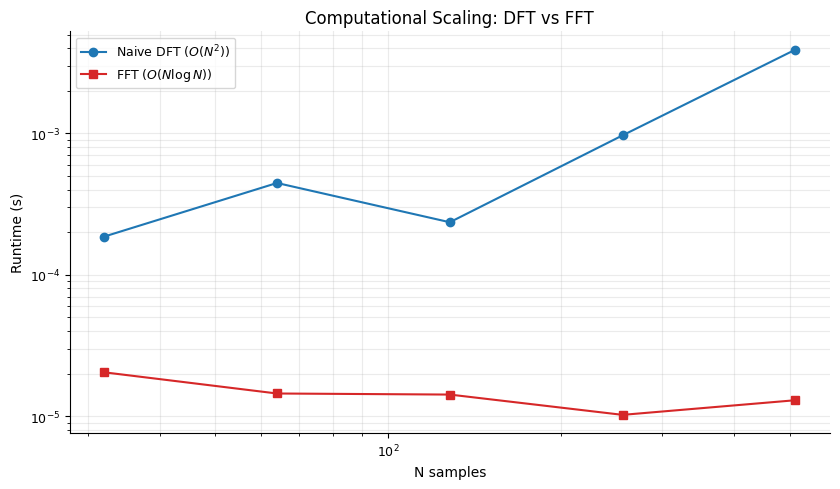

ugradio.dft available. Max |FFT - ugradio.dft| at N=256: 9.243e-13


In [26]:
# THEORY_DEMO: DFT vs FFT scaling; optional check against ugradio.dft
def naive_dft(x: np.ndarray) -> np.ndarray:
    n = x.size
    idx = np.arange(n)
    W = np.exp(-2j * np.pi * np.outer(idx, idx) / n)
    return W @ x


rng = np.random.default_rng(2026)
sizes = np.array([32, 64, 128, 256, 512], dtype=int)
fft_times = []
dft_times = []

for n in sizes:
    x = rng.normal(size=n) + 1j * rng.normal(size=n)

    t0 = time.perf_counter()
    _ = np.fft.fft(x)
    fft_times.append(time.perf_counter() - t0)

    t0 = time.perf_counter()
    _ = naive_dft(x)
    dft_times.append(time.perf_counter() - t0)

fig, ax = plt.subplots(figsize=(8.5, 5.0))
ax.loglog(sizes, dft_times, "o-", label="Naive DFT ($O(N^2)$)")
ax.loglog(sizes, fft_times, "s-", label=r"FFT ($O(N\log N)$)")
ax.set_xlabel("N samples")
ax.set_ylabel("Runtime (s)")
ax.set_title("Computational Scaling: DFT vs FFT")
ax.grid(True, which="both", alpha=0.25)
ax.legend(loc="best")
plt.tight_layout()
plt.show()

try:
    import ugradio.dft as ugr_dft

    n_check = 256
    x_check = rng.normal(size=n_check) + 1j * rng.normal(size=n_check)
    x_np = np.fft.fft(x_check)
    _, x_ug_centered = ugr_dft.dft(x_check, vsamp=1.0)
    x_ug = np.fft.ifftshift(np.asarray(x_ug_centered, dtype=np.complex128))
    max_err = np.max(np.abs(x_np - x_ug))
    print(f"ugradio.dft available. Max |FFT - ugradio.dft| at N={n_check}: {max_err:.3e}")
except Exception:
    print("ugradio.dft not available in this environment; skipped backend comparison demo.")

<!-- THEORY_FRAMEWORK:CONV_MIX_FIR -->
### 3.5 Convolution Theorem, Heterodyne Mixers, and FIR Filtering

**Convolution theorem**:
$$y(t)=x(t)*h(t) \Longleftrightarrow Y(f)=X(f)H(f).$$
So filtering is multiplication in frequency; equivalently, frequency-selective multiplication corresponds to convolution in time.

For discrete FIR filters:
$$y[n]=\sum_{m=0}^{M-1} b[m]x[n-m], \qquad
H(e^{j\omega})=\sum_{m=0}^{M-1} b[m]e^{-j\omega m}.$$

**Heterodyne mixer model** (time-domain multiplication):
$$x_{RF}(t)=A_{RF}\cos(2\pi f_{RF}t),\;
x_{LO}(t)=A_{LO}\cos(2\pi f_{LO}t),$$
$$x_{IF}(t)=x_{RF}(t)x_{LO}(t)=\frac{A_{RF}A_{LO}}{2}
\left[\cos 2\pi(f_{RF}-f_{LO})t + \cos 2\pi(f_{RF}+f_{LO})t\right].$$
This produces sum and difference terms (ideal case), with additional intermod products when nonlinearity is present. A downstream FIR low-pass commonly retains the difference (IF/beat) term while suppressing higher-frequency components.


Convolution theorem relative error: 3.013e-16


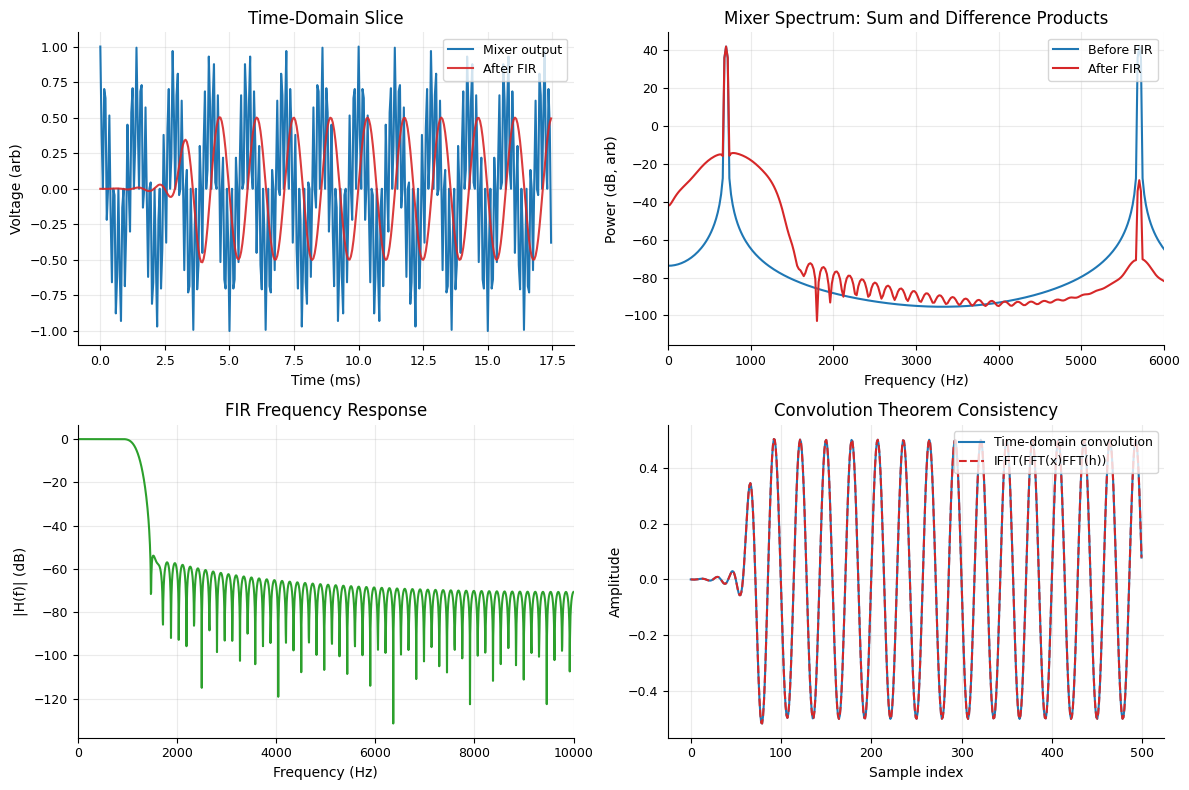

In [27]:
# THEORY_DEMO: Mixer products, FIR low-pass selection, and convolution theorem check
fs_hz = 20_000.0
duration_s = 0.05
t_s = np.arange(0.0, duration_s, 1.0 / fs_hz)

f_lo_hz = 2500.0
f_rf_hz = 3200.0
lo = np.cos(2.0 * np.pi * f_lo_hz * t_s)
rf = np.cos(2.0 * np.pi * f_rf_hz * t_s)
mixed = lo * rf

# FIR low-pass to keep |f_rf-f_lo| component and attenuate sum product.
num_taps = 129
cutoff_hz = 1200.0
b = signal.firwin(num_taps, cutoff=cutoff_hz, fs=fs_hz)
filtered = signal.lfilter(b, [1.0], mixed)

# Convolution theorem consistency check.
conv_direct = np.convolve(mixed, b, mode="full")
n_fft = conv_direct.size
conv_freq = np.fft.ifft(np.fft.fft(mixed, n_fft) * np.fft.fft(b, n_fft)).real
conv_rel_err = np.linalg.norm(conv_direct - conv_freq) / max(np.linalg.norm(conv_direct), 1e-15)
print(f"Convolution theorem relative error: {conv_rel_err:.3e}")


def one_sided_power(x: np.ndarray, fs: float) -> tuple[np.ndarray, np.ndarray]:
    win = np.hanning(x.size)
    X = np.fft.rfft(x * win)
    f = np.fft.rfftfreq(x.size, d=1.0 / fs)
    p = np.abs(X) ** 2
    return f, p


f_raw, p_raw = one_sided_power(mixed, fs_hz)
f_filt, p_filt = one_sided_power(filtered, fs_hz)

w_hz, h = signal.freqz(b, worN=2048, fs=fs_hz)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(t_s[:350] * 1e3, mixed[:350], label="Mixer output")
axes[0, 0].plot(t_s[:350] * 1e3, filtered[:350], label="After FIR", alpha=0.9)
axes[0, 0].set_xlabel("Time (ms)")
axes[0, 0].set_ylabel("Voltage (arb)")
axes[0, 0].set_title("Time-Domain Slice")
axes[0, 0].legend(loc="upper right")
axes[0, 0].grid(True, alpha=0.25)

axes[0, 1].plot(f_raw, 10.0 * np.log10(np.maximum(p_raw, 1e-18)), label="Before FIR")
axes[0, 1].plot(f_filt, 10.0 * np.log10(np.maximum(p_filt, 1e-18)), label="After FIR")
axes[0, 1].set_xlim(0.0, 6000.0)
axes[0, 1].set_xlabel("Frequency (Hz)")
axes[0, 1].set_ylabel("Power (dB, arb)")
axes[0, 1].set_title("Mixer Spectrum: Sum and Difference Products")
axes[0, 1].legend(loc="upper right")
axes[0, 1].grid(True, alpha=0.25)

axes[1, 0].plot(w_hz, 20.0 * np.log10(np.maximum(np.abs(h), 1e-8)), color="C2")
axes[1, 0].set_xlim(0.0, fs_hz / 2.0)
axes[1, 0].set_xlabel("Frequency (Hz)")
axes[1, 0].set_ylabel("|H(f)| (dB)")
axes[1, 0].set_title("FIR Frequency Response")
axes[1, 0].grid(True, alpha=0.25)

axes[1, 1].plot(conv_direct[:500], label="Time-domain convolution")
axes[1, 1].plot(conv_freq[:500], linestyle="--", label="IFFT(FFT(x)FFT(h))")
axes[1, 1].set_xlabel("Sample index")
axes[1, 1].set_ylabel("Amplitude")
axes[1, 1].set_title("Convolution Theorem Consistency")
axes[1, 1].legend(loc="upper right")
axes[1, 1].grid(True, alpha=0.25)

fig.tight_layout()
plt.show()

## 4. Experimental Methods and Validation Protocol

### 4.1 Hardware
- SDR + Raspberry Pi
- Signal generator(s)
- Mixers (DSB/SSB configurations)
- Oscilloscope
- Splitter/combiner and phase-delay cables

### 4.2 Calibration and Pre-Checks (Mistrust-Everything)
- Warm-up and drift check.
- Cable/connector continuity checks.
- Frequency calibration against known tone(s).
- Amplitude linearity/saturation check at SDR input.
- First-capture discard/stale-buffer test.
- Noise floor baseline with terminated input.

### 4.3 Data Management
- File naming, metadata schema, and run manifest.
- Separation of raw, processed, and derived products.
- Reproducibility notes: random seeds, package version, git commit.


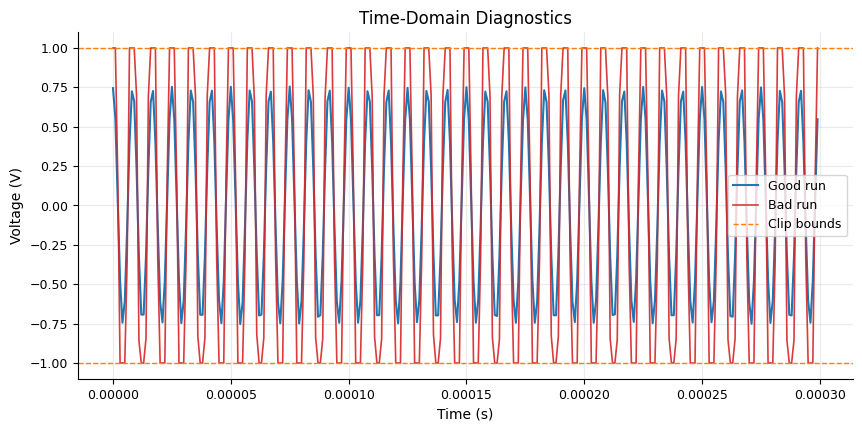

In [28]:
# SIM_RUNNER: Calibration/Pre-Checks -> F3
fs_precheck = 1.0e6
n_precheck = 4096

# Use a controlled synthetic tone for pre-check acceptance diagnostics.
good_voltage = np.real(
    generate_multi_tone(
        frequencies_hz=np.array([120_000.0]),
        sample_rate_hz=fs_precheck,
        n_samples=n_precheck,
        amplitudes_v=np.array([0.75]),
        phases_rad=np.array([0.0]),
        complex_output=True,
        noise_std_v=0.005,
        rng=RNG,
    )
)
time_s_precheck = sample_times(good_voltage.size, fs_precheck)

# Construct a clipping-like failure case for calibration diagnostics.
bad_voltage = np.clip(2.8 * good_voltage + 0.05, -1.0, 1.0)

f3_builder = TimeDomainComparisonFigureBuilder()
fig_f3, _ = f3_builder.build(
    time_s_precheck,
    good_voltage,
    bad_voltage,
    clip_limits_v=(-1.0, 1.0),
    sample_slice=TIME_DOMAIN_SLICE,
)
save_figure(fig_f3, "F3_time_domain_good_vs_bad_sim.png")


<!-- SIM_CAPTION:CAL_PRECHECK_F3 -->
**Figure F3 (Simulation): Calibration/pre-check time-domain diagnostics (good vs bad run).** A short waveform slice highlights clean in-range behavior in the nominal capture and clipping/saturation artifacts in the rejected capture, motivating pre-check acceptance gates before promoting data to experiment analysis.


## 5. One-Day Execution Plan (Tomorrow)

| Time Block | Priority | Task | Deliverable |
| --- | --- | --- | --- |
| 0:00-0:45 | Must | Calibration + baseline checks | Table T1 + Figure F3 |
| 0:45-2:00 | Must | E1 Nyquist/Aliasing + E2 Bandpass | Figures F2, F4 |
| 2:00-3:00 | Must | E3 Spectra conventions | Figures F5/F6 |
| 3:00-4:00 | Must | E4 Leakage/Resolution | Figures F7/F8 |
| 4:00-5:00 | Must | E5 Noise/Radiometer | Figures F10/F11/F12 |
| 5:00-6:30 | Must | E6 DSB + intermod | Figures F13/F15 |
| 6:30-7:30 | Stretch | E7 SSB + R820T comparison | Figures F16/F18 |
| 7:30-8:00 | Must | Data integrity + backup + notes | Run manifest + gaps list |

If time collapses, keep the must-have set and document what was not completed.


## 6. Figure Blueprint (Master List)

| Fig ID | Panel Concept | Purpose | Data Source | Plot Spec | Section |
| --- | --- | --- | --- | --- | --- |
| F1 | Setup + signal chain diagram | Document physical configuration and controls | Lab photo + schematic | Annotated image | Methods |
| F2 | Measured alias map vs prediction | Validate Nyquist/aliasing behavior | E1 tone sweeps | Scatter/line + residual inset | E1 |
| F3 | Time-domain samples (good vs bad run) | Show stale-buffer or clipping diagnostics used as acceptance gate | Calibration/pre-check captures | Time series overlay | Calibration/Methods |
| F4 | SDR bandpass response (default vs FIR mode) | Characterize front-end filtering | E2 frequency sweeps | Gain-vs-freq curves | E2 |
| F5 | Complex voltage spectrum components | Clarify real/imag and sign conventions | E3 single-tone runs | Multi-panel spectrum | E3 |
| F6 | Voltage vs power spectra comparison | Demonstrate correct spectral interpretation | E3 runs | Shared-axis comparison | E3 |
| F7 | Leakage with bin-centered vs off-bin tones | Quantify leakage mechanism | E4 controlled tones | Log-power spectra | E4 |
| F8 | Two-tone resolution vs sample count N | Show frequency resolution limit | E4 two-generator runs | Stacked spectra or heatmap | E4 |
| F9 | Spectra across multiple Nyquist windows | Verify replication/folding structure | E4 window-extended transforms | Window-indexed panels | E4 |
| F10 | Noise histogram + Gaussian fit | Test noise distribution assumptions | E5 long noise capture | Histogram + model overlay | E5 |
| F11 | Radiometer scaling (sigma vs averaging) | Test 1/sqrt(M) behavior | E5 block averages | Log-log fit with CI | E5 |
| F12 | ACF and power-spectrum consistency | Cross-validate transform relations | E5 ACF + FFT outputs | Two-panel comparison | E5 |
| F13 | DSB mixer output spectrum | Verify sum/difference products | E6 LO/RF runs | Spectrum with annotated lines | E6 |
| F14 | Inverse-transformed DSB filtered waveform | Demonstrate Fourier-domain filtering | E6 processed spectrum | Time-domain reconstruction | E6 |
| F15 | Intermodulation spur survey | Characterize non-ideal mixer behavior | E6 high-dynamic-range spectrum | Log spectrum + spur labels | E6 |
| F16 | SSB IQ phase behavior (upper/lower sideband) | Demonstrate sideband discrimination | E7 IQ captures | Phase trajectory/phasor panels | E7 |
| F17 | Reverted DSB comparison | Show loss of sideband sign discrimination | E7 reconfigured cable run | Comparison panels | E7 |
| F18 | R820T internal vs external mixer comparison | Relate discrete setup to SDR integrated path | E7 SDR complex captures | Side-by-side spectra | E7 |


## 7. Table Blueprint (Master List)

| Table ID | Title | Required Columns | Section |
| --- | --- | --- | --- |
| T1 | Calibration and instrument health log | timestamp, instrument, check, measured value, tolerance, pass/fail, notes | Methods |
| T2 | Acquisition parameter manifest | run_id, experiment, fs, center freq, tone(s), power, mixer config, cable config, N samples | Methods |
| T3 | Aliasing prediction residuals | run_id, f_true, fs, predicted_alias, measured_alias, residual, uncertainty | E1 |
| T4 | Bandpass characterization summary | mode, passband estimate, rolloff metric, ripple, fit residuals | E2 |
| T5 | Leakage and resolution metrics | run_id, N, delta_f_bin, leakage metric, min resolvable delta_f | E4 |
| T6 | Noise and radiometer fit | block size, n_avg, sigma_power, fitted slope, expected slope, chi2/dof | E5 |
| T7 | Mixer line catalog and spur map | config, LO, RF, expected line, observed line, level, interpretation | E6/E7 |
| T8 | Goal-coverage and evidence matrix | goal_id, evidence items, pass/fail/partial, limitations | Discussion |


In [29]:
# Optional: status tracker for figures/tables during the lab day


figure_ids = [f"F{i}" for i in range(1, 19)]
table_ids = [f"T{i}" for i in range(1, 9)]

fig_status = pd.DataFrame({"figure_id": figure_ids, "status": "not started", "path": "", "notes": ""})
tab_status = pd.DataFrame({"table_id": table_ids, "status": "not started", "path": "", "notes": ""})

fig_status.head(), tab_status.head()


(  figure_id       status path notes
 0        F1  not started           
 1        F2  not started           
 2        F3  not started           
 3        F4  not started           
 4        F5  not started           ,
   table_id       status path notes
 0       T1  not started           
 1       T2  not started           
 2       T3  not started           
 3       T4  not started           
 4       T5  not started           )

## 8. Minimum Viable Deliverable Set (If Time-Limited)

Prioritize these first:
- Figures: F2, F4, F6, F8, F11, F13, F16
- Tables: T1, T2, T3, T6, T7

This minimum still covers all major section-2 goals with explicit quantitative evidence.


## 9. Experiment Series

Each experiment section below has a fixed template so you can fill results quickly while data are fresh.


## 9A. Physical vs Simulation Execution Matrix

| Experiment | Physical Work (lab bench) | Simulation Work (model bench) | Must-Have Output |
| --- | --- | --- | --- |
| E1 Nyquist/Aliasing | Sweep tone frequency and sample rate with SDR captures | Generate alias predictions and synthetic sampled tones | Alias map + residuals (F2, T3) |
| E2 Bandpass | Fixed-amplitude frequency sweep in default and alias/FIR modes | Apply ideal/estimated filter response to synthetic tones | Bandpass curves + summary metrics (F4, T4) |
| E3 Spectra | Single-tone/two-tone captures for complex voltage spectra | Verify symmetry/sign conventions using synthetic real/complex signals | Voltage vs power comparison (F5, F6) |
| E4 Leakage/Resolution | Off-bin vs bin-centered tones; two-tone resolution runs vs N | Reproduce leakage/resolution with controlled synthetic tones | Leakage + resolution plots (F7, F8, F9, T5) |
| E5 Noise/ACF/Radiometer | Long noise captures with anti-alias filter | Simulated Gaussian noise and averaging law checks | Histogram, scaling fit, ACF match (F10-F12, T6) |
| E6 DSB/Intermod | LO/RF mixer runs with product identification | Ideal mixer + nonlinear spur model | Product and spur catalog (F13-F15, T7) |
| E7 SSB/R820T | SSB phase-delay setup, revert to DSB, compare with R820T | IQ/phasor sideband model and comparison runs | Sideband/IQ comparison (F16-F18, T7) |


## 9B. Physical Experiment SOP (Bench Runbook)

Use this section as the live bench procedure for physical runs.

### Global Preflight (Run Once)

1. Power on signal generators, SDR host (Raspberry Pi), and allow at least 15 minutes of warm-up.
2. Start a run manifest and log every run with `run_id`, timestamp, wiring, `f_s`, `N`, `direct`, FIR mode, frequencies, and powers.
3. Connect SDR input to a 50 ohm termination and record one baseline capture.
4. Connect one signal generator to SDR input and start at low power (for example `-60 dBm`).
5. Run SDR ADC guard pre-checks before any experiment capture and reject blocks when `ADC RMS < 10`, `ADC max >= 127`, or `ADC min <= -128`.
6. Implement a try/retry capture loop during pre-checks: if a block fails ADC guards, log it and re-read until a valid block passes.
7. Define one anchor configuration and repeat it throughout the day to monitor drift.
8. Save raw data immediately after each run and perform one mid-day backup.

### Capture Convention (Use for All Experiments)

1. Standard sample-rate set: `1.0, 1.6, 2.4, 3.2 MHz`.
2. For E1 sweeps use `N=2048`, `nblocks=6`, `stale_blocks=1` (drop first stale block, save 5 clean blocks).
3. Use longer captures for noise/resolution (`N>=16000`) per experiment-specific settings.
4. If a capture fails ADC guards (`ADC RMS < 10`, `ADC max >= 127`, `ADC min <= -128`), retry acquisition and do not promote that block to analysis.
5. Keep SDR gain fixed unless the experiment explicitly requires a change.

### E1 Nyquist and Aliasing (Physical Procedure)

1. Wiring/config: `SigGen1 -> SDR input`, `device_index=0`, `direct=True`, `gain=0.0`, `N=2048`, `nblocks=6`, `stale_blocks=1`.
2. Sweep `f_s = {1.0, 1.6, 2.4, 3.2} MHz`.
3. For each `f_s`, use 24 linear tone points over `[0, 4 f_Nyquist]` and omit exact `0 Hz` in physical runs.
4. Capture both FIR modes: `default (fir_coeffs=None)` and `alias_hack (fir_coeffs=[0, ..., 0, 2047])`.
5. Use fixed power tiers per `(f_s, f_true, fir_mode)`:
   - `default`: `-10, 0, +10 dBm`
   - `alias_hack`: `-50, -40, -30 dBm`
6. Save each tier run immediately with deterministic `run_id`; on resume, skip completed `run_id`s.
7. Quality labels: keep `passes_guard` and `is_clipped` in metadata/progress; no bisection/target-RMS search.
8. Record outputs for `F2`, `T3`.

### E2 SDR Bandpass Characterization (Physical Procedure)

1. Keep wiring as in E1.
2. Hold source amplitude constant at the validated non-clipping level.
3. Sweep frequency over the planned range and capture spectra.
4. Repeat in default mode and alias/FIR-modified mode.
5. Re-measure three anchor frequencies every ~15 minutes for drift tracking.
6. Quality gate: response curve is smooth; investigate sudden jumps immediately.
7. Record outputs for `F4`, `T4`.

### E3 Voltage and Power Spectra (Physical Procedure)

1. Keep wiring as in E1.
2. Capture one high-quality single-tone run and one two-tone run.
3. Save raw voltage time series (not just processed spectra).
4. If possible, acquire one non-direct run (`direct=False`) for complex IQ comparison.
5. Quality gate: power spectrum is real/non-negative; voltage spectrum conventions are consistent.
6. Record outputs for `F5`, `F6`.

### E4 Leakage, Resolution, and Nyquist Windows (Physical Procedure)

1. Leakage runs: `SigGen1 -> SDR` with bin-centered and intentionally off-bin tones.
2. Resolution runs: combine `SigGen1` and `SigGen2` with a splitter in reverse, then feed SDR.
3. Sweep `delta f` while increasing `N` to identify minimum resolvable spacing.
4. Keep one representative run for multi-window spectral re-analysis.
5. Quality gate: off-bin leakage visible on log scale and resolution improves with larger `N`.
6. Record outputs for `F7`, `F8`, `F9`, `T5`.

### E5 Noise, ACF, and Radiometer (Physical Procedure)

1. Preferred wiring: `Noise source -> band-pass filter -> SDR`.
2. Fallback wiring: terminated input if noise source is unavailable.
3. Capture long noise records and multiple blocks for averaging tests (`N_avg=1,2,4,8,16`).
4. Capture at least one long block for ACF analysis (`~16000` samples).
5. Quality gate: mean/variance stationarity over time chunks.
6. Record outputs for `F10`, `F11`, `F12`, `T6`.

### E6 DSB Mixer and Intermodulation (Physical Procedure)

1. Wiring: `LO generator -> mixer LO`, `RF generator -> mixer RF`, `mixer IF -> SDR`.
2. Start at conservative generator powers; increase only after confirming SDR headroom.
3. Acquire runs for `f_RF = f_LO + delta f` and `f_RF = f_LO - delta f`.
4. Capture one wide dynamic-range run for spur/intermod survey.
5. Perform Fourier-domain filtering on one run to isolate low-frequency beat content.
6. Quality gate: identify expected sum/difference lines before spur interpretation.
7. Record outputs for `F13`, `F14`, `F15`, `T7`.

### E7 SSB, Reverted DSB, and R820T (Physical Procedure)

1. Build external SSB chain with two mixers and split RF/LO paths.
2. Reverted DSB case first: equal LO cable lengths; capture `+delta f` and `-delta f`.
3. Insert ~90 degree LO delay in one branch and repeat captures.
4. Delay estimate: `L_90 ~= 0.7*c/(4*f_LO)` extra cable length.
5. Compare phase/sign behavior between reverted DSB and SSB configurations.
6. Acquire internal SDR mixer comparison runs with `direct=False` and complex IQ capture.
7. Quality gate: sideband-sign discrimination appears in SSB and R820T cases, not reverted DSB.
8. Record outputs for `F16`, `F17`, `F18`, `T7`.

### If Oscilloscope Access Is Limited

1. Use internal SDR complex IQ (`direct=False`) as the primary sideband-sign test.
2. Keep external SSB/DSB captures, but mark phase conclusions as limited by instrumentation.

### End-of-Day Closure

1. Back up all raw data to a second location.
2. Verify run manifest consistency with figure/table placeholders.
3. Mark missing or failed runs with reason codes.
4. Update experiment sections with run IDs while details are fresh.
5. Tag remaining items as post-lab analysis tasks.


### E1. Nyquist Sampling and Aliasing

**Objective:** Validate measured alias frequencies against Nyquist predictions across multiple sampling rates, FIR modes, and fixed power tiers.

**Physical Steps (bench):**
1. Configure SDR direct mode with `device_index=0`, `direct=True`, `gain=0.0`, `N=2048`, `nblocks=6`, `stale_blocks=1` (save 5 clean blocks).
2. For each `f_s in {1.0, 1.6, 2.4, 3.2} MHz`, generate 24 linear tone points over `[0, 4 f_Nyquist]` and omit exact `0 Hz` physically.
3. For each `(f_true, f_s)`, acquire both FIR modes: `default` and `alias_hack=[0, ..., 0, 2047]`.
4. Use fixed power tiers per FIR mode:
   - `default`: `-10, 0, +10 dBm`
   - `alias_hack`: `-50, -40, -30 dBm`
5. Save each tier run immediately; use resume-safe `run_id` skip logic to avoid duplicates.

**Simulation Steps (model):**
1. Compute predicted aliases for each `(f_true, f_s)` pair.
2. Generate synthetic sampled sinusoids with matching sample counts and optional noise.
3. Extract measured/simulated peak frequencies with one shared analysis routine.

**Calibration and Diagnostics:**
- First-capture discard/stale-buffer check (`nblocks=6`, drop first, save 5).
- ADC guard labels retained per run: `passes_guard` and `is_clipped`.
- Residual check: `f_alias,measured - f_alias,predicted`.
- No bisection/target-RMS search in E1 (fixed-tier acquisition).

**Data collected (run IDs):**  
**Primary figures/tables:** F2, T3  

**Analysis (processing and quantitative tests):**
- Peak-finding method and uncertainty estimate.
- Residual distribution summary (mean, RMS, worst case).

**Key quantitative results:**  

**Discussion (interpretation and model agreement):**
- Where prediction and measurement agree/disagree.
- Likely causes for disagreement (clock offset, filter behavior, SNR).

**Limitations and next checks:**


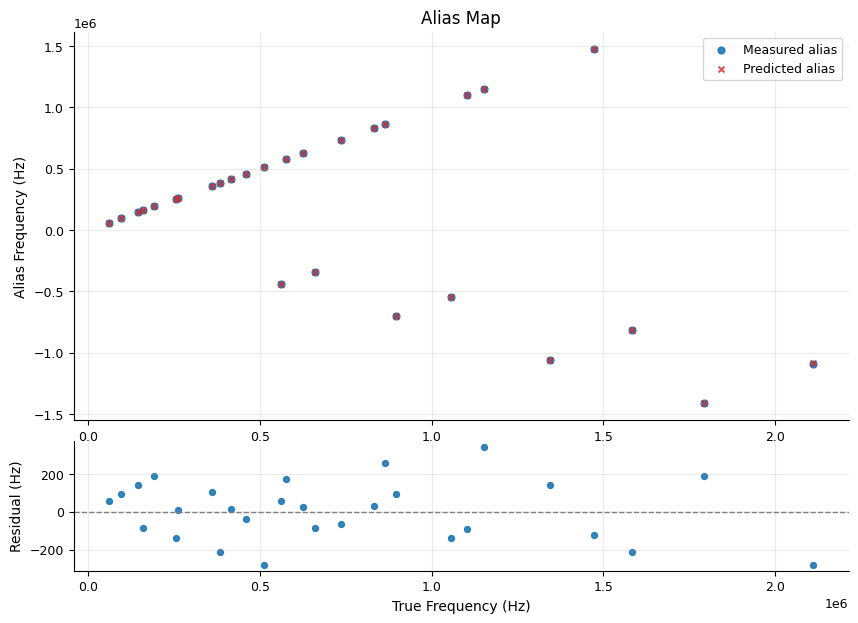

,run_id,f_true_hz,sample_rate_hz,predicted_alias_hz,measured_alias_hz,residual_hz,n_samples,amplitude_v,noise_std_v,complex_output
0,sim_e1_000,60000.0,1000000.0,60000.0,60058.593750,58.593750,4096,1.0,0.01,True
1,sim_e1_001,160000.0,1000000.0,160000.0,159912.109375,-87.890625,4096,1.0,0.01,True
2,sim_e1_002,260000.0,1000000.0,260000.0,260009.765625,9.765625,4096,1.0,0.01,True
3,sim_e1_003,360000.0,1000000.0,360000.0,360107.421875,107.421875,4096,1.0,0.01,True
4,sim_e1_004,460000.0,1000000.0,460000.0,459960.937500,-39.062500,4096,1.0,0.01,True


In [30]:
# SIM_RUNNER: E1 Nyquist/Aliasing -> F2
fs_values = np.array([1.0e6, 1.6e6, 2.4e6, 3.2e6], dtype=float)
n_samples_e1 = 4096

f_true_grid: list[float] = []
fs_grid: list[float] = []
for fs in fs_values:
    nyq = fs / 2.0
    f_points = np.array([0.12, 0.32, 0.52, 0.72, 0.92, 1.12, 1.32], dtype=float) * nyq
    f_true_grid.extend(f_points.tolist())
    fs_grid.extend([float(fs)] * f_points.size)

alias_sim = simulate_alias_sweep(
    np.array(f_true_grid),
    np.array(fs_grid),
    n_samples=n_samples_e1,
    amplitude_v=1.0,
    noise_std_v=0.01,
    complex_output=True,
    rng=RNG,
)
alias_table = alias_sim.table.sort_values(["sample_rate_hz", "f_true_hz"], kind="stable").reset_index(drop=True)

f2_builder = AliasMapFigureBuilder()
fig_f2, _ = f2_builder.build(
    alias_table["f_true_hz"].to_numpy(dtype=float),
    alias_table["measured_alias_hz"].to_numpy(dtype=float),
    predicted_alias_hz=alias_table["predicted_alias_hz"].to_numpy(dtype=float),
    residual_hz=alias_table["residual_hz"].to_numpy(dtype=float),
)
save_figure(fig_f2, "F2_alias_map_sim.png")

alias_table.head()


<!-- SIM_CAPTION:E1 -->
**Figure F2 (Simulation): Measured alias map vs prediction.** Synthetic tone sweeps over multiple sample rates reproduce Nyquist folding into the principal zone. The residual panel confirms agreement between recovered peak frequency and analytical alias prediction within bin-level limits.


#### E1 Physical Pipeline Integration (Raw -> Processed)

This block connects the report notebook directly to the physical E1 pipeline. It ingests `data/raw/e1.tar.gz`, writes interim/processed tables, and updates the physical F2 figure used in analysis.


,metric,value
0,raw_source,/Users/junruiting/GitHub/ugradio/labs/01/data/...
1,run_catalog_rows,545
2,qc_analysis_pass_rows,545
3,qc_recommended_pass_rows,321
4,t2_rows,545
5,t3_rows,545
6,f2_figure_path,/Users/junruiting/GitHub/ugradio/labs/01/repor...
7,rebuild_performed,False


,run_id,f_true_hz,sample_rate_hz,predicted_alias_hz,measured_alias_hz,residual_hz,abs_residual_hz,uncertainty_hz,fir_mode,power_tier_dbm,status,adc_passes_guard,adc_is_clipped,qc_analysis_pass,qc_recommended_pass
0,e1_sr1000000_f1043478_idx11_fir_alias_hack__pm...,1.043478e+06,1.000000e+06,43478.234379,43457.032401,-21.201977,21.201977,0.0,alias_hack,-30.0,captured,True,False,True,True
1,e1_sr1000000_f1043478_idx11_fir_alias_hack__pm...,1.043478e+06,1.000000e+06,43478.234379,43457.032401,-21.201977,21.201977,0.0,alias_hack,-40.0,captured_guard_fail,False,False,True,False
2,e1_sr1000000_f1043478_idx11_fir_alias_hack__pm...,1.043478e+06,1.000000e+06,43478.234379,43457.032401,-21.201977,21.201977,0.0,alias_hack,-50.0,captured_guard_fail,False,False,True,False
3,e1_sr1000000_f1043478_idx11_fir_default__pm10p0,1.043478e+06,1.000000e+06,43478.234379,43457.032401,-21.201977,21.201977,0.0,default,-10.0,captured,True,False,True,True
4,e1_sr1000000_f1043478_idx11_fir_default__pp0p0,1.043478e+06,1.000000e+06,43478.234379,43457.032401,-21.201977,21.201977,0.0,default,0.0,captured,True,False,True,True


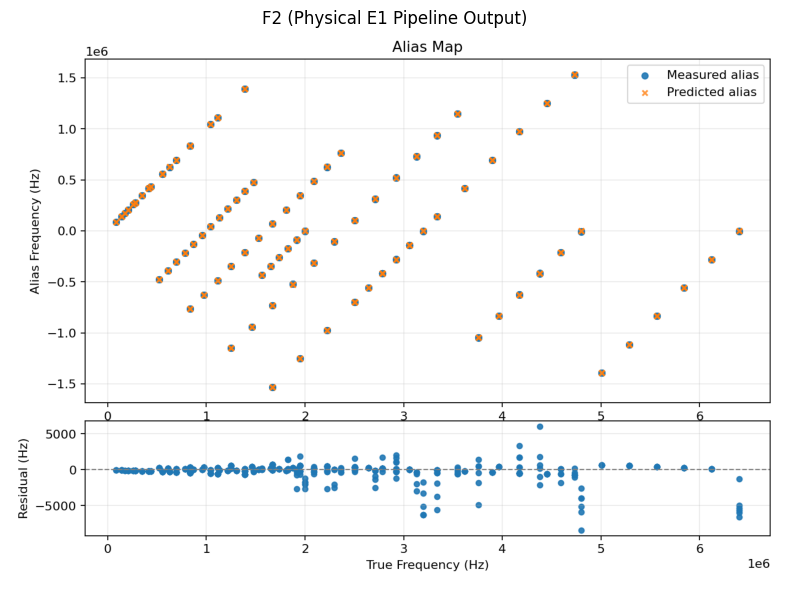

In [31]:
# PIPELINE_RUNNER: E1 physical raw -> processed integration
REBUILD_E1_PHYSICAL = False

E1_RAW_SOURCE = LAB_DIR / DEFAULT_E1_RAW_SOURCE
E1_RUN_CATALOG_PATH = LAB_DIR / DEFAULT_E1_RUN_CATALOG_PATH
E1_QC_CATALOG_PATH = LAB_DIR / DEFAULT_E1_QC_CATALOG_PATH
E1_T2_TABLE_PATH = LAB_DIR / DEFAULT_E1_T2_TABLE_PATH
E1_T3_TABLE_PATH = LAB_DIR / DEFAULT_E1_T3_TABLE_PATH
E1_F2_PHYSICAL_PATH = LAB_DIR / DEFAULT_E1_F2_FIGURE_PATH

if not E1_RAW_SOURCE.exists():
    raise FileNotFoundError(f"E1 raw source not found: {E1_RAW_SOURCE}")

need_rebuild = REBUILD_E1_PHYSICAL or not (
    E1_RUN_CATALOG_PATH.exists()
    and E1_QC_CATALOG_PATH.exists()
    and E1_T2_TABLE_PATH.exists()
    and E1_T3_TABLE_PATH.exists()
    and E1_F2_PHYSICAL_PATH.exists()
)

if need_rebuild:
    e1_run_catalog = build_e1_run_catalog(E1_RAW_SOURCE)
    e1_qc_catalog = build_e1_qc_catalog(e1_run_catalog)
    e1_t2_physical = build_e1_t2_table(e1_qc_catalog)
    e1_t3_physical = build_e1_t3_table(e1_qc_catalog, use_qc_analysis_pass=True)

    write_dataframe_csv(e1_run_catalog, E1_RUN_CATALOG_PATH)
    write_dataframe_csv(e1_qc_catalog, E1_QC_CATALOG_PATH)
    write_table_manifest_csv(e1_t2_physical, E1_T2_TABLE_PATH)
    write_table_manifest_csv(e1_t3_physical, E1_T3_TABLE_PATH)
    write_e1_alias_figure(e1_t3_physical, E1_F2_PHYSICAL_PATH)
else:
    e1_run_catalog = pd.read_csv(E1_RUN_CATALOG_PATH)
    e1_qc_catalog = pd.read_csv(E1_QC_CATALOG_PATH)
    e1_t2_physical = pd.read_csv(E1_T2_TABLE_PATH)
    e1_t3_physical = pd.read_csv(E1_T3_TABLE_PATH)

summary_e1_physical = pd.DataFrame(
    {
        "metric": [
            "raw_source",
            "run_catalog_rows",
            "qc_analysis_pass_rows",
            "qc_recommended_pass_rows",
            "t2_rows",
            "t3_rows",
            "f2_figure_path",
            "rebuild_performed",
        ],
        "value": [
            str(E1_RAW_SOURCE),
            len(e1_run_catalog),
            int(e1_qc_catalog["qc_analysis_pass"].fillna(False).sum()) if "qc_analysis_pass" in e1_qc_catalog.columns else np.nan,
            int(e1_qc_catalog["qc_recommended_pass"].fillna(False).sum()) if "qc_recommended_pass" in e1_qc_catalog.columns else np.nan,
            len(e1_t2_physical),
            len(e1_t3_physical),
            str(E1_F2_PHYSICAL_PATH),
            bool(need_rebuild),
        ],
    }
)

display(summary_e1_physical)
display(e1_t3_physical.head())

img_f2_physical = plt.imread(E1_F2_PHYSICAL_PATH)
fig_f2_physical, ax_f2_physical = plt.subplots(figsize=(10, 6))
ax_f2_physical.imshow(img_f2_physical)
ax_f2_physical.set_title("F2 (Physical E1 Pipeline Output)")
ax_f2_physical.axis("off")
fig_f2_physical.tight_layout()
display(fig_f2_physical)
plt.close(fig_f2_physical)

generated_figure_labels.append(str(E1_F2_PHYSICAL_PATH))


<!-- PHYS_CAPTION:E1 -->
**Figure F2 (Physical): Measured alias map vs prediction from E1 hardware runs.** The figure is generated from `data/raw/e1.tar.gz` via the E1 pipeline and persisted to `report/figures/F2_alias_map_physical.png`, with corresponding processed rows in `data/processed/e1/tables/T3_e1_alias_residuals.csv`.


### E2. SDR Bandpass Characterization

**Objective:** Measure effective SDR gain response vs frequency and compare operating modes.

**Physical Steps (bench):**
1. Hold source amplitude constant; sweep frequency through planned range.
2. Acquire spectra in default mode and alias/FIR-modified mode.
3. Repeat anchor frequencies to estimate short-term gain drift.

**Simulation Steps (model):**
1. Use candidate filter shapes (ideal + empirical fit) to predict measured roll-off.
2. Apply filter model to synthetic tones and derive expected gain curve.
3. Compare modeled and measured passband/rolloff metrics.

**Calibration and Diagnostics:**
- Confirm source amplitude stability with scope before/after sweep.
- Track baseline noise floor and subtract consistently.
- Flag outliers from connector reseats or transient jumps.

**Data collected (run IDs):**  
**Primary figures/tables:** F4, T4  

**Analysis (processing and quantitative tests):**
- Gain normalization method and reference selection.
- Passband/ripple/rolloff metric extraction.

**Key quantitative results:**  

**Discussion (interpretation and model agreement):**
- Physical meaning of bandpass shape.
- Differences between default and FIR-modified behavior.

**Limitations and next checks:**


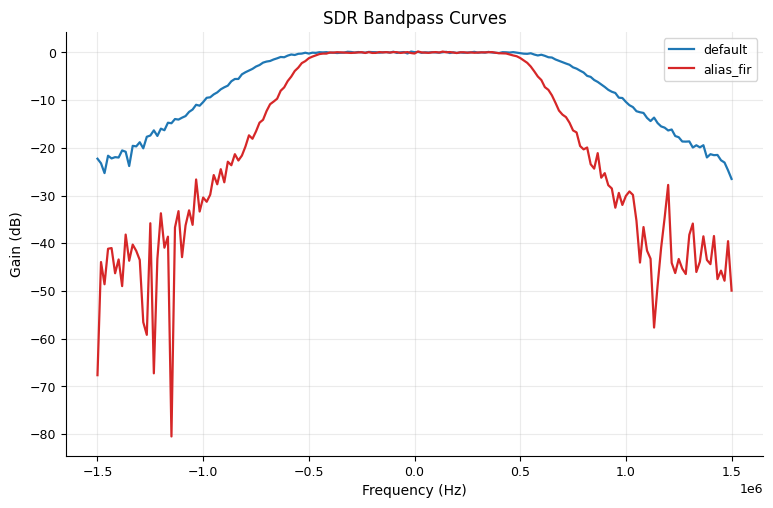

,frequency_hz,gain_db
0,-1.500000e+06,-22.282857
1,-1.483333e+06,-23.248149
2,-1.466667e+06,-25.298618
3,-1.450000e+06,-21.656144
4,-1.433333e+06,-22.221314


In [32]:
# SIM_RUNNER: E2 Bandpass -> F4
frequency_sweep_hz = np.linspace(-1.5e6, 1.5e6, 181)

curve_default = simulate_bandpass_sweep(
    frequency_sweep_hz,
    sample_rate_hz=3.2e6,
    n_samples=4096,
    source_amplitude_v=1.0,
    center_hz=0.0,
    passband_hz=1.5e6,
    order=4,
    measurement_noise_std_v=0.01,
    mode="default",
    rng=RNG,
)
curve_fir = simulate_bandpass_sweep(
    frequency_sweep_hz,
    sample_rate_hz=3.2e6,
    n_samples=4096,
    source_amplitude_v=1.0,
    center_hz=0.0,
    passband_hz=1.1e6,
    order=6,
    measurement_noise_std_v=0.01,
    mode="alias_fir",
    rng=RNG,
)

gain_by_mode = {
    "default": curve_default["gain_db"].to_numpy(dtype=float),
    "alias_fir": curve_fir["gain_db"].to_numpy(dtype=float),
}

f4_builder = BandpassFigureBuilder()
fig_f4, _ = f4_builder.build(
    curve_default["frequency_hz"].to_numpy(dtype=float),
    gain_by_mode,
)
save_figure(fig_f4, "F4_bandpass_curves_sim.png")
curve_default[["frequency_hz", "gain_db"]].head()


<!-- SIM_CAPTION:E2 -->
**Figure F4 (Simulation): SDR bandpass response (default vs alias/FIR mode).** Simulated gain curves show mode-dependent passband shape, with the FIR-modified path exhibiting stronger edge attenuation and narrower effective bandwidth relative to default mode.


#### E2 Physical Pipeline Integration (Raw -> Processed)\n\nThis block ingests `data/raw/e2.tar.gz`, writes E2 interim/processed artifacts, and updates the physical F4 figure for the report.

,metric,value
0,raw_source,/Users/junruiting/GitHub/ugradio/labs/01/data/...
1,run_catalog_rows,234
2,qc_analysis_pass_rows,234
3,qc_recommended_pass_rows,90
4,curve_rows,200
5,t2_rows,234
6,t4_rows,4
7,f4_figure_path,/Users/junruiting/GitHub/ugradio/labs/01/repor...
8,rebuild_performed,False


,mode,passband_estimate_hz,rolloff_metric_db_per_hz,ripple_db,fit_residuals_db,sample_rate_hz,fir_mode,selected_power_dbm,selected_point_count,recommended_fraction,peak_frequency_hz,peak_gain_db
0,default@1.0MHz,412377.050061,0.000175,2.401076,10.344986,1000000.026,default,-30.0,50,0.46,318209.738413,0.0
1,default@1.6MHz,705207.586447,0.000189,2.569855,10.512431,1600000.000,default,-30.0,50,0.42,240098.122254,0.0
2,default@2.4MHz,983227.638401,0.000215,2.173231,10.486574,2400000.000,default,-30.0,50,0.40,300205.497517,0.0
3,default@3.2MHz,887723.245588,0.000128,2.405557,11.423441,3200000.000,default,-30.0,50,0.52,270224.347301,0.0


,frequency_hz,amplitude_v,reference_amplitude_v,gain_linear,gain_db,mode,run_id,curve_label,fir_mode,sample_rate_hz_nominal,...,status,qc_analysis_pass,qc_recommended_pass,selection_preferred_power_dbm,selection_used_preferred_mode_power,source_kind,source_path,source_member,frequency_normalized_to_nyquist,frequency_normalized_to_fs
0,10000.000000,1.980181,116.343409,0.017020,-35.380739,default@1.0MHz,e2_sr1000000_f10000_idx00_fir_default__pm30p0,default@1.0MHz,default,1000000.026,...,captured_guard_fail,True,False,-30.0,True,tar,data/raw/e2.tar.gz,e2/e2_sr1000000_f10000_idx00_fir_default__pm30...,0.020000,0.010000
1,11141.913842,2.221345,116.343409,0.019093,-34.382515,default@1.0MHz,e2_sr1000000_f11142_idx01_fir_default__pm30p0,default@1.0MHz,default,1000000.026,...,captured_guard_fail,True,False,-30.0,True,tar,data/raw/e2.tar.gz,e2/e2_sr1000000_f11142_idx01_fir_default__pm30...,0.022284,0.011142
2,12414.224406,2.745916,116.343409,0.023602,-32.541090,default@1.0MHz,e2_sr1000000_f12414_idx02_fir_default__pm30p0,default@1.0MHz,default,1000000.026,...,captured_guard_fail,True,False,-30.0,True,tar,data/raw/e2.tar.gz,e2/e2_sr1000000_f12414_idx02_fir_default__pm30...,0.024828,0.012414
3,13831.821875,3.322444,116.343409,0.028557,-30.885682,default@1.0MHz,e2_sr1000000_f13832_idx03_fir_default__pm30p0,default@1.0MHz,default,1000000.026,...,captured_guard_fail,True,False,-30.0,True,tar,data/raw/e2.tar.gz,e2/e2_sr1000000_f13832_idx03_fir_default__pm30...,0.027664,0.013832
4,15411.296761,4.091408,116.343409,0.035167,-29.077379,default@1.0MHz,e2_sr1000000_f15411_idx04_fir_default__pm30p0,default@1.0MHz,default,1000000.026,...,captured_guard_fail,True,False,-30.0,True,tar,data/raw/e2.tar.gz,e2/e2_sr1000000_f15411_idx04_fir_default__pm30...,0.030823,0.015411


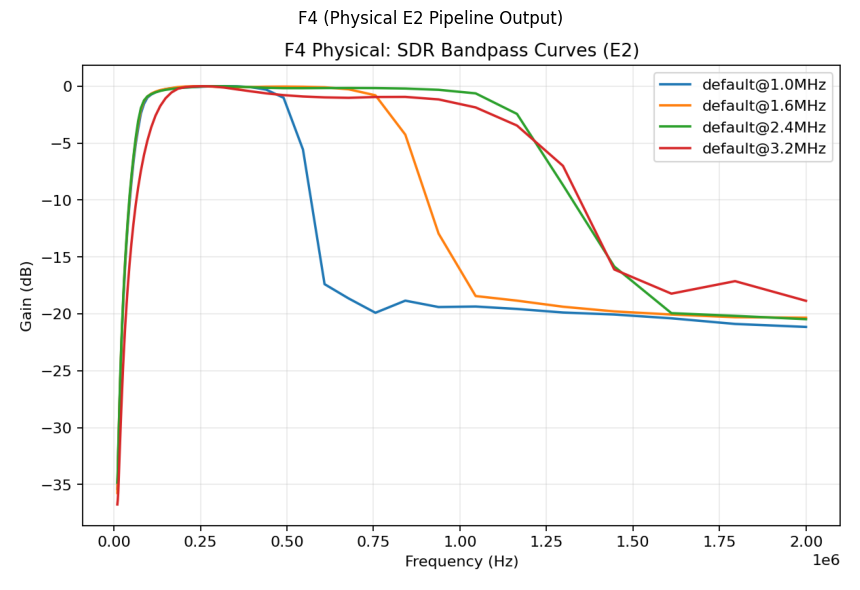

In [12]:
# PIPELINE_RUNNER: E2 physical raw -> processed integration
REBUILD_E2_PHYSICAL = False

E2_RAW_SOURCE = LAB_DIR / DEFAULT_E2_RAW_SOURCE
E2_RUN_CATALOG_PATH = LAB_DIR / DEFAULT_E2_RUN_CATALOG_PATH
E2_QC_CATALOG_PATH = LAB_DIR / DEFAULT_E2_QC_CATALOG_PATH
E2_CURVE_TABLE_PATH = LAB_DIR / DEFAULT_E2_CURVE_TABLE_PATH
E2_T2_TABLE_PATH = LAB_DIR / DEFAULT_E2_T2_TABLE_PATH
E2_T4_TABLE_PATH = LAB_DIR / DEFAULT_E2_T4_TABLE_PATH
E2_F4_PHYSICAL_PATH = LAB_DIR / DEFAULT_E2_F4_FIGURE_PATH

if not E2_RAW_SOURCE.exists():
    raise FileNotFoundError(f"E2 raw source not found: {E2_RAW_SOURCE}")

need_rebuild_e2 = REBUILD_E2_PHYSICAL or not (
    E2_RUN_CATALOG_PATH.exists()
    and E2_QC_CATALOG_PATH.exists()
    and E2_CURVE_TABLE_PATH.exists()
    and E2_T2_TABLE_PATH.exists()
    and E2_T4_TABLE_PATH.exists()
    and E2_F4_PHYSICAL_PATH.exists()
)

if need_rebuild_e2:
    e2_run_catalog = build_e2_run_catalog(E2_RAW_SOURCE)
    e2_qc_catalog = build_e2_qc_catalog(e2_run_catalog)
    e2_curve_table = build_e2_bandpass_curve_table(
        e2_qc_catalog,
        use_qc_analysis_pass=True,
        preferred_power_dbm=-10.0,
    )
    e2_t2_physical = build_e2_t2_table(e2_qc_catalog)
    e2_t4_physical = build_e2_t4_table(e2_curve_table)

    write_dataframe_csv(e2_run_catalog, E2_RUN_CATALOG_PATH)
    write_dataframe_csv(e2_qc_catalog, E2_QC_CATALOG_PATH)
    write_dataframe_csv(e2_curve_table, E2_CURVE_TABLE_PATH)
    write_table_manifest_csv(e2_t2_physical, E2_T2_TABLE_PATH)
    write_table_manifest_csv(e2_t4_physical, E2_T4_TABLE_PATH)
    write_e2_bandpass_figure(
        e2_curve_table,
        E2_F4_PHYSICAL_PATH,
        reference_sample_rate_hz=1.0e6,
    )
else:
    e2_run_catalog = pd.read_csv(E2_RUN_CATALOG_PATH)
    e2_qc_catalog = pd.read_csv(E2_QC_CATALOG_PATH)
    e2_curve_table = pd.read_csv(E2_CURVE_TABLE_PATH)
    e2_t2_physical = pd.read_csv(E2_T2_TABLE_PATH)
    e2_t4_physical = pd.read_csv(E2_T4_TABLE_PATH)

summary_e2_physical = pd.DataFrame(
    {
        "metric": [
            "raw_source",
            "run_catalog_rows",
            "qc_analysis_pass_rows",
            "qc_recommended_pass_rows",
            "curve_rows",
            "t2_rows",
            "t4_rows",
            "f4_figure_path",
            "rebuild_performed",
        ],
        "value": [
            str(E2_RAW_SOURCE),
            len(e2_run_catalog),
            int(e2_qc_catalog["qc_analysis_pass"].fillna(False).sum()) if "qc_analysis_pass" in e2_qc_catalog.columns else np.nan,
            int(e2_qc_catalog["qc_recommended_pass"].fillna(False).sum()) if "qc_recommended_pass" in e2_qc_catalog.columns else np.nan,
            len(e2_curve_table),
            len(e2_t2_physical),
            len(e2_t4_physical),
            str(E2_F4_PHYSICAL_PATH),
            bool(need_rebuild_e2),
        ],
    }
)

display(summary_e2_physical)
display(e2_t4_physical.head())
display(e2_curve_table.head())

img_f4_physical = plt.imread(E2_F4_PHYSICAL_PATH)
fig_f4_physical, ax_f4_physical = plt.subplots(figsize=(10, 6))
ax_f4_physical.imshow(img_f4_physical)
ax_f4_physical.set_title("F4 (Physical E2 Pipeline Output)")
ax_f4_physical.axis("off")
fig_f4_physical.tight_layout()
display(fig_f4_physical)
plt.close(fig_f4_physical)

generated_figure_labels.append(str(E2_F4_PHYSICAL_PATH))


<!-- PHYS_CAPTION:E2 -->\n**Figure F4 (Physical): SDR bandpass response from E2 hardware runs.** The figure is generated from `data/raw/e2.tar.gz` via the E2 pipeline and persisted to `report/figures/F4_bandpass_curves_physical.png`, with processed rows in `data/processed/e2/tables/T4_e2_bandpass_summary.csv`.

### E3. Voltage and Power Spectra

**Objective:** Demonstrate correct use and interpretation of complex voltage spectra and power spectra.

**Physical Steps (bench):**
1. Acquire one-tone and two-tone SDR runs with controlled amplitudes.
2. Compute complex FFT outputs and corresponding power spectra.
3. Compare spectra for real-signal captures and, where available, complex IQ captures.

**Simulation Steps (model):**
1. Generate real and complex synthetic signals with known line frequencies/phases.
2. Compute voltage and power spectra with the same pipeline used for lab data.
3. Validate symmetry/sign and normalization conventions.

**Calibration and Diagnostics:**
- Unit audit for axes and normalization constants.
- Parseval-style energy consistency check.
- Verify `fftshift` is plotting-only, not used before inverse transforms.

**Data collected (run IDs):**  
**Primary figures/tables:** F5, F6  

**Analysis (processing and quantitative tests):**
- Spectrum normalization and unit conversion details.
- Symmetry and energy-conservation checks.

**Key quantitative results:**  

**Discussion (interpretation and model agreement):**
- How voltage and power spectra answer different questions.
- Consequences of sign/symmetry conventions for later mixer work.

**Limitations and next checks:**


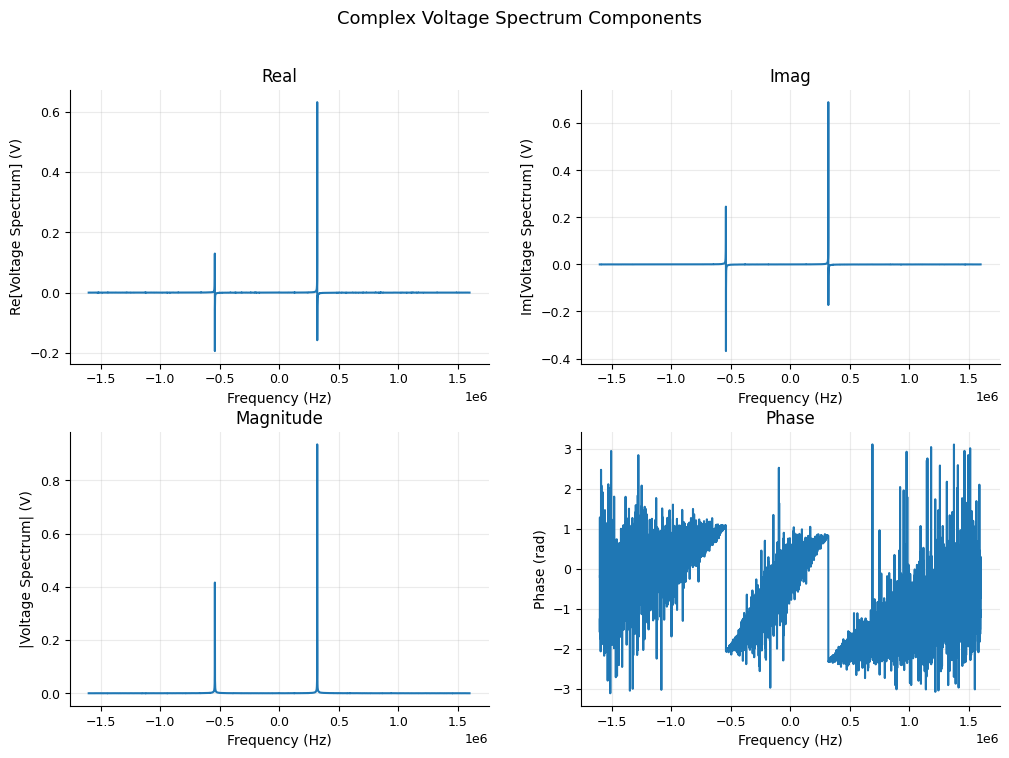

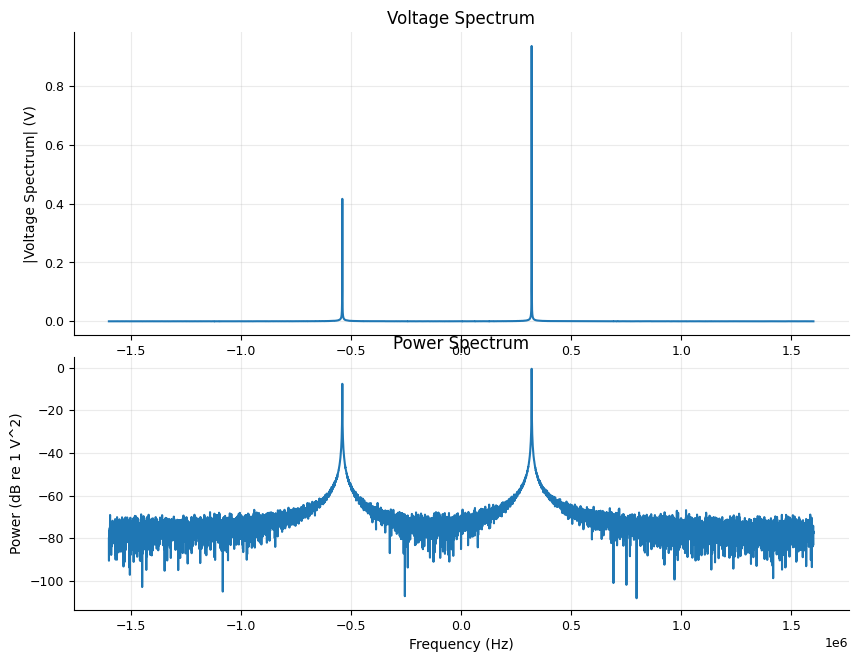

In [13]:
# SIM_RUNNER: E3 Voltage/Power spectra -> F5, F6
fs_e3 = 3.2e6
n_e3 = 8192

voltage_e3 = generate_multi_tone(
    frequencies_hz=np.array([320_000.0, -540_000.0]),
    sample_rate_hz=fs_e3,
    n_samples=n_e3,
    amplitudes_v=np.array([1.0, 0.55]),
    phases_rad=np.array([0.2, -0.8]),
    complex_output=True,
    noise_std_v=0.01,
    rng=RNG,
)

frequency_v_hz, spectrum_v = voltage_spectrum(
    voltage_e3,
    sample_rate_hz=fs_e3,
    center=True,
    scaling="amplitude",
)
frequency_p_hz, power_v2 = power_spectrum(
    voltage_e3,
    sample_rate_hz=fs_e3,
    center=True,
    scaling="power",
)

f5_builder = ComplexVoltageComponentsFigureBuilder()
fig_f5, _ = f5_builder.build(frequency_v_hz, spectrum_v)
save_figure(fig_f5, "F5_complex_voltage_components_sim.png")

f6_builder = VoltagePowerComparisonFigureBuilder()
fig_f6, _ = f6_builder.build(
    frequency_v_hz,
    spectrum_v,
    power_v2,
    voltage_component="magnitude",
    power_db=True,
)
save_figure(fig_f6, "F6_voltage_vs_power_sim.png")


<!-- SIM_CAPTION:E3 -->
**Figure F5 (Simulation): Complex voltage spectrum components.** Real, imaginary, magnitude, and phase panels of a controlled multi-tone complex signal verify sign conventions and component interpretation used in downstream mixer analysis.

**Figure F6 (Simulation): Voltage vs power spectral representation.** The same synthetic signal is shown as complex-voltage magnitude and power spectrum to emphasize that voltage spectra preserve phasor information while power spectra provide non-negative energy distribution.


#### E3 Physical Pipeline Integration (Raw -> Processed)\n\nThis block ingests `data/raw/e3.tar.gz`, writes E3 interim/processed artifacts, and updates physical F5/F6 figures for the report.

,metric,value
0,raw_source,/Users/junruiting/GitHub/ugradio/labs/01/data/...
1,run_catalog_rows,4
2,qc_analysis_pass_rows,4
3,qc_recommended_pass_rows,4
4,spectrum_rows,8192
5,spectrum_run_ids_count,4
6,single_tone_count,3
7,double_tone_count,1
8,run_ids,"e3_20260209T054629Z, e3_20260209T054708Z, e3_2..."
9,t2_rows,4


,run_id,mode,combination_class,n_signal_generators,tones_hz_json,source_power_dbm_mean,adc_mean_block_rms
0,e3_20260209T054629Z,two_tone,double_tone,2,"[333333.3, 250000.0]",-27.9,50.728364
1,e3_20260209T054708Z,single_tone,single_tone,1,[333333.3],-27.9,41.347083
2,e3_20260209T054801Z,single_tone,single_tone,1,[250000.0],-27.9,62.701597
3,e3_20260209T054900Z,single_tone,single_tone,1,[333333.3],-24.6,50.976152


,run_id,experiment,sample_rate_hz,center_frequency_hz,tones_hz,source_power_dbm,mixer_config,cable_config,n_samples,run_kind,status,n_blocks_saved,sample_rate_hz_requested,sample_rate_hz_actual,sample_rate_error_hz,target_vrms_v,mode,notes,qc_analysis_pass,qc_recommended_pass
0,e3_20260209T054629Z,E3,3200000.0,0.0,"[333333.3, 250000.0]",-27.9,NaN,NaN,2048,physical_voltage_power,captured,5,3200000.0,3200000.0,0.0,0.0140,two_tone,NaN,True,True
1,e3_20260209T054708Z,E3,3200000.0,0.0,[333333.3],-27.9,NaN,NaN,2048,physical_voltage_power,captured,5,3200000.0,3200000.0,0.0,0.0201,single_tone,NaN,True,True
2,e3_20260209T054801Z,E3,3200000.0,0.0,[250000.0],-27.9,NaN,NaN,2048,physical_voltage_power,captured,5,3200000.0,3200000.0,0.0,0.0201,single_tone,NaN,True,True
3,e3_20260209T054900Z,E3,3200000.0,0.0,[333333.3],-24.6,NaN,NaN,2048,physical_voltage_power,captured,5,3200000.0,3200000.0,0.0,0.0301,single_tone,NaN,True,True


,run_id,mode,sample_rate_hz,frequency_hz,voltage_real_v,voltage_imag_v,voltage_mag_v,voltage_phase_rad,voltage_mag_block_std_v,power_v2,...,power_from_voltage_v2,power_consistency_delta_v2,n_blocks_used,qc_analysis_pass,qc_recommended_pass,adc_passes_guard,adc_is_clipped,source_power_dbm,target_vrms_v,tones_hz_json
0,e3_20260209T054629Z,two_tone,3200000.0,-1600000.0,-0.003809,0.000000,0.003809,3.141593,0.006879,0.000078,...,0.000015,0.000064,5,True,True,True,False,-27.9,0.014,"[333333.3, 250000.0]"
1,e3_20260209T054629Z,two_tone,3200000.0,-1598437.5,0.001599,0.002140,0.002671,0.928917,0.005483,0.000127,...,0.000007,0.000119,5,True,True,True,False,-27.9,0.014,"[333333.3, 250000.0]"
2,e3_20260209T054629Z,two_tone,3200000.0,-1596875.0,0.001119,-0.001890,0.002196,-1.036407,0.006760,0.000163,...,0.000005,0.000158,5,True,True,True,False,-27.9,0.014,"[333333.3, 250000.0]"
3,e3_20260209T054629Z,two_tone,3200000.0,-1595312.5,0.002355,0.002748,0.003619,0.862144,0.006933,0.000160,...,0.000013,0.000147,5,True,True,True,False,-27.9,0.014,"[333333.3, 250000.0]"
4,e3_20260209T054629Z,two_tone,3200000.0,-1593750.0,0.003385,-0.004014,0.005251,-0.870276,0.002476,0.000082,...,0.000028,0.000055,5,True,True,True,False,-27.9,0.014,"[333333.3, 250000.0]"


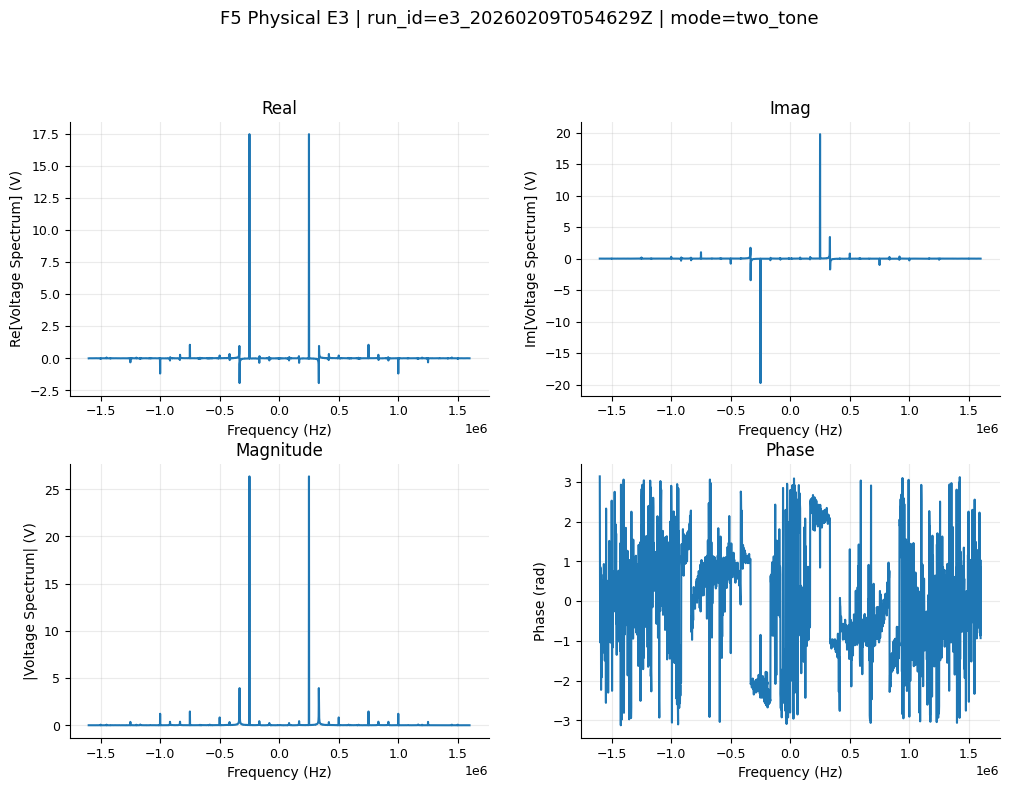

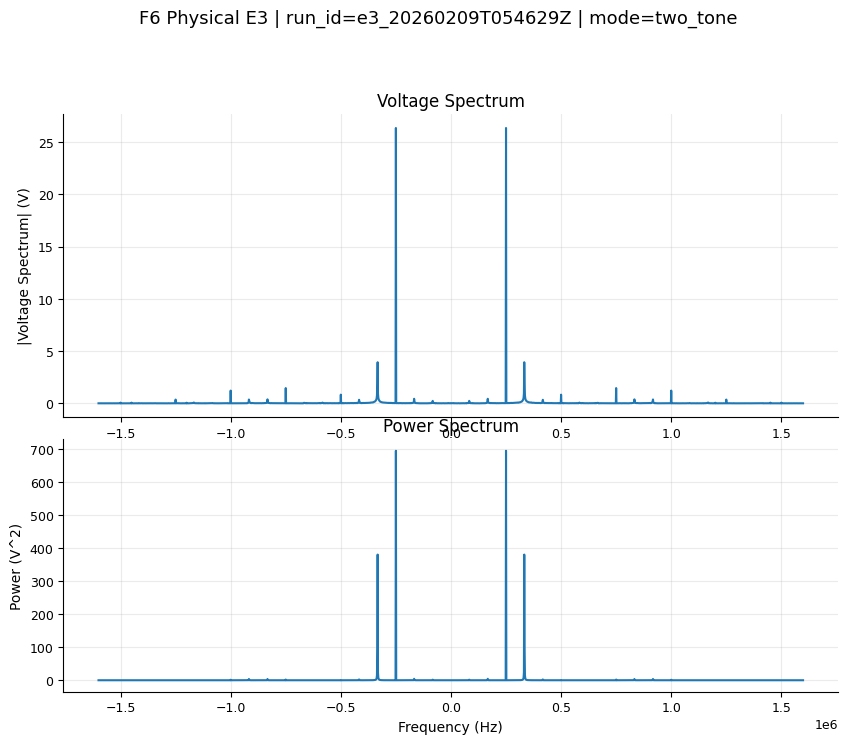

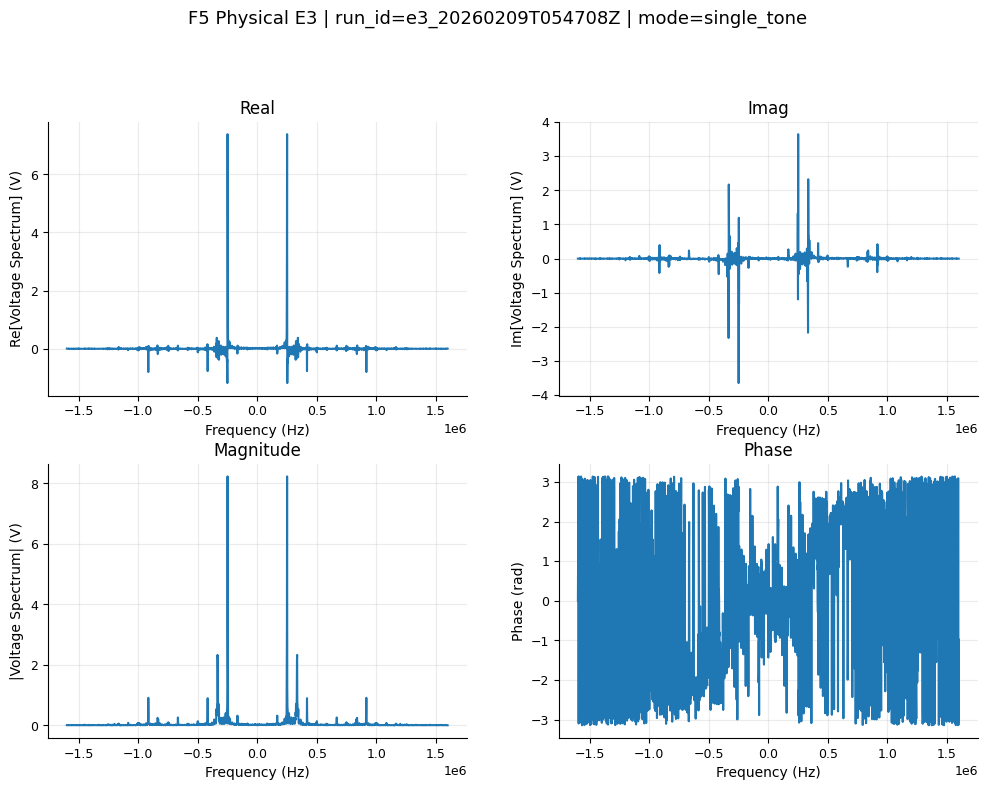

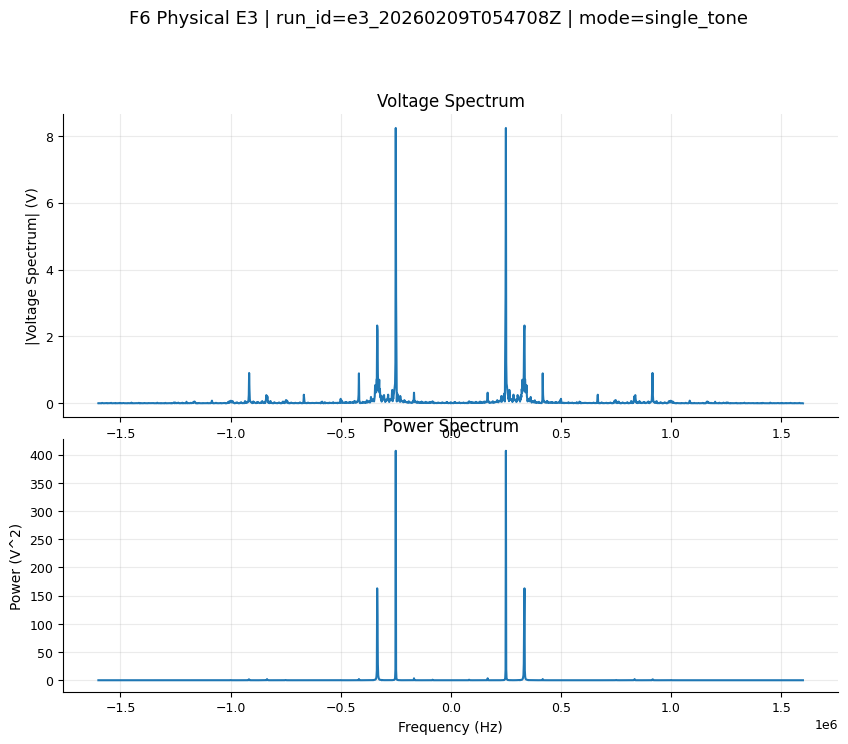

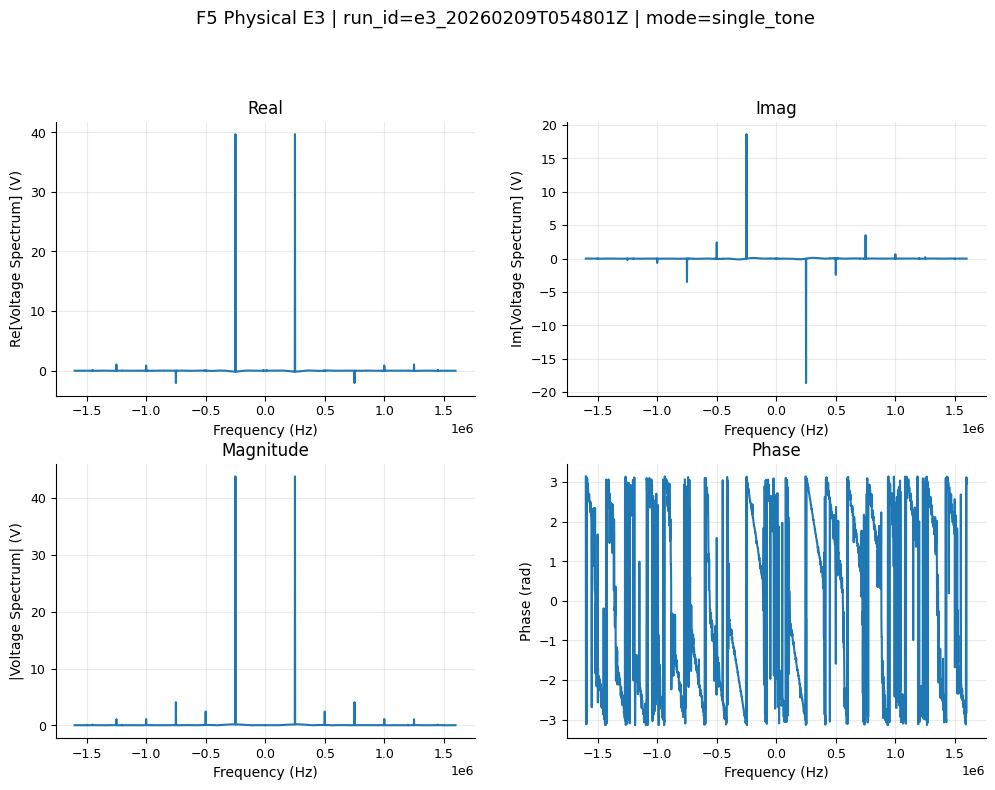

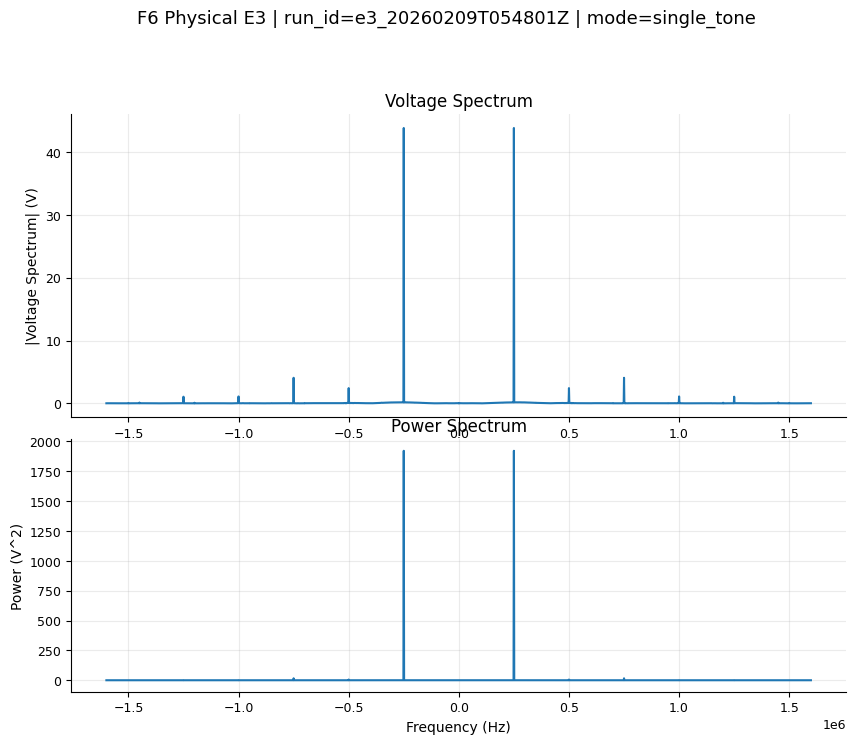

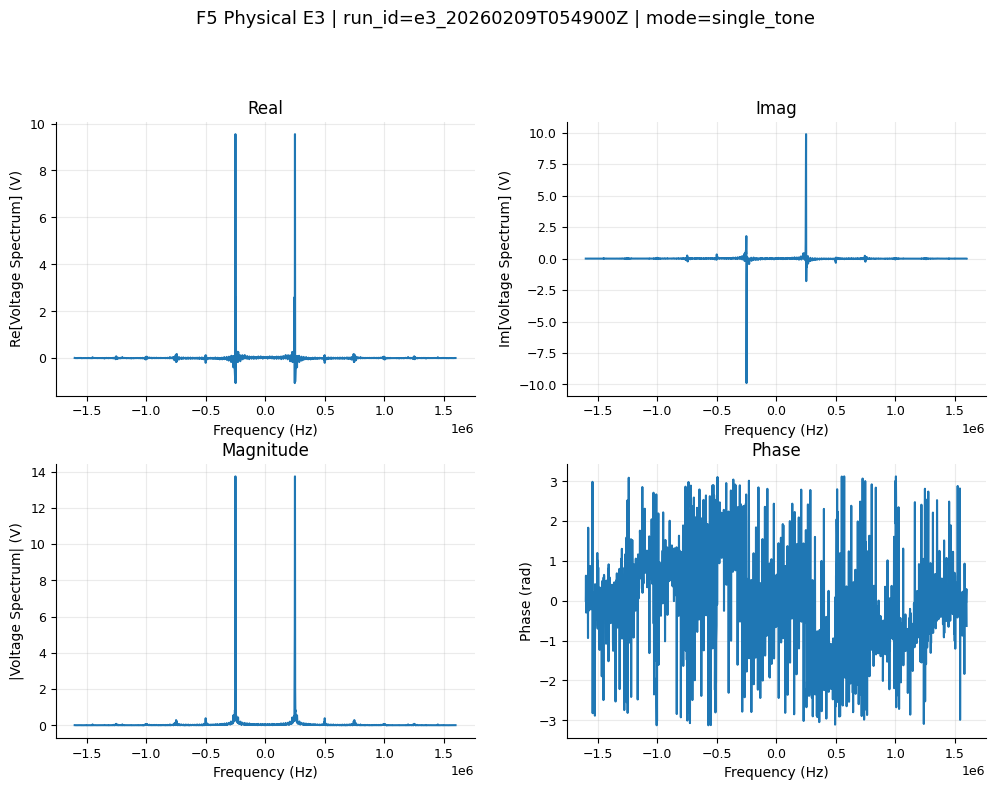

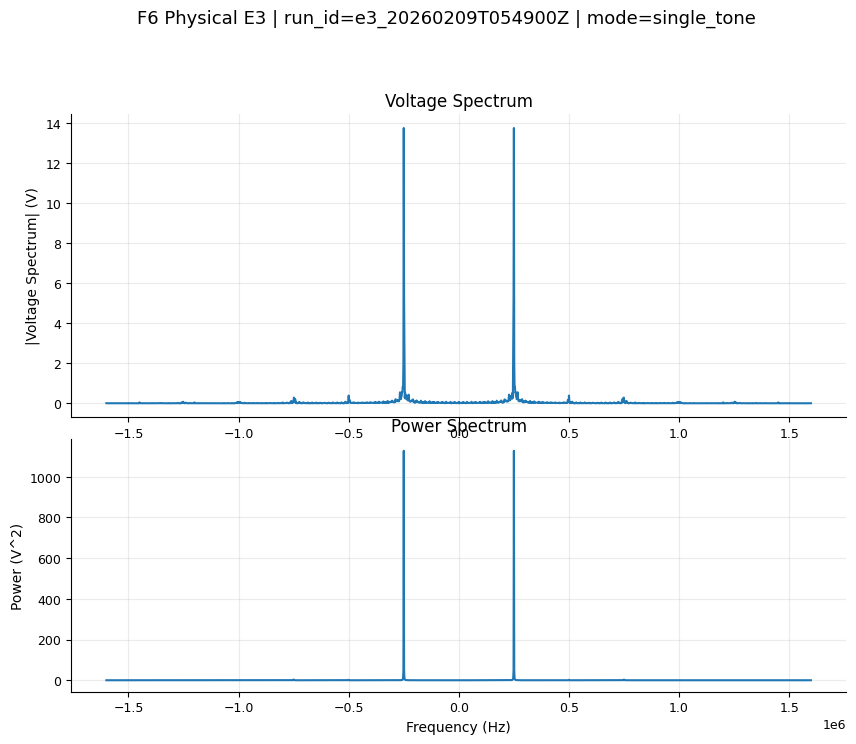

In [14]:
# PIPELINE_RUNNER: E3 physical raw -> processed integration
REBUILD_E3_PHYSICAL = False

E3_RAW_SOURCE = LAB_DIR / DEFAULT_E3_RAW_SOURCE
E3_RUN_CATALOG_PATH = LAB_DIR / DEFAULT_E3_RUN_CATALOG_PATH
E3_QC_CATALOG_PATH = LAB_DIR / DEFAULT_E3_QC_CATALOG_PATH
E3_SPECTRUM_TABLE_PATH = LAB_DIR / DEFAULT_E3_SPECTRUM_TABLE_PATH
E3_T2_TABLE_PATH = LAB_DIR / DEFAULT_E3_T2_TABLE_PATH
E3_F5_PHYSICAL_PATH = LAB_DIR / DEFAULT_E3_F5_FIGURE_PATH
E3_F6_PHYSICAL_PATH = LAB_DIR / DEFAULT_E3_F6_FIGURE_PATH

if not E3_RAW_SOURCE.exists():
    raise FileNotFoundError(f"E3 raw source not found: {E3_RAW_SOURCE}")

need_rebuild_e3 = REBUILD_E3_PHYSICAL or not (
    E3_RUN_CATALOG_PATH.exists()
    and E3_QC_CATALOG_PATH.exists()
    and E3_SPECTRUM_TABLE_PATH.exists()
    and E3_T2_TABLE_PATH.exists()
    and E3_F5_PHYSICAL_PATH.exists()
    and E3_F6_PHYSICAL_PATH.exists()
)

if need_rebuild_e3:
    e3_run_catalog = build_e3_run_catalog(E3_RAW_SOURCE)
    e3_qc_catalog = build_e3_qc_catalog(e3_run_catalog)
    e3_spectrum_profile = build_e3_spectrum_profiles(
        e3_qc_catalog,
        use_qc_analysis_pass=True,
    )
    e3_t2_physical = build_e3_t2_table(e3_qc_catalog)

    write_dataframe_csv(e3_run_catalog, E3_RUN_CATALOG_PATH)
    write_dataframe_csv(e3_qc_catalog, E3_QC_CATALOG_PATH)
    write_dataframe_csv(e3_spectrum_profile, E3_SPECTRUM_TABLE_PATH)
    write_table_manifest_csv(e3_t2_physical, E3_T2_TABLE_PATH)

    e3_run_ids_sorted = sorted(e3_spectrum_profile["run_id"].astype(str).dropna().unique().tolist())
    e3_reference_run_id = e3_run_ids_sorted[0]
    write_e3_voltage_components_figure(
        e3_spectrum_profile,
        E3_F5_PHYSICAL_PATH,
        run_id=e3_reference_run_id,
    )
    write_e3_voltage_power_figure(
        e3_spectrum_profile,
        E3_F6_PHYSICAL_PATH,
        power_db=False,
        run_id=e3_reference_run_id,
    )
else:
    e3_run_catalog = pd.read_csv(E3_RUN_CATALOG_PATH)
    e3_qc_catalog = pd.read_csv(E3_QC_CATALOG_PATH)
    e3_spectrum_profile = pd.read_csv(E3_SPECTRUM_TABLE_PATH)
    e3_t2_physical = pd.read_csv(E3_T2_TABLE_PATH)

e3_run_ids_sorted = sorted(e3_spectrum_profile["run_id"].astype(str).dropna().unique().tolist())
if len(e3_run_ids_sorted) == 0:
    raise ValueError("No E3 run IDs found in spectrum profile.")

run_summary = e3_run_catalog.copy()
if "n_signal_generators" in run_summary.columns:
    n_sg = pd.to_numeric(run_summary["n_signal_generators"], errors="coerce").fillna(0)
    run_summary["combination_class"] = np.where(n_sg >= 2, "double_tone", "single_tone")
else:
    run_summary["combination_class"] = run_summary.get("mode", pd.Series("unknown", index=run_summary.index))

summary_e3_physical = pd.DataFrame(
    {
        "metric": [
            "raw_source",
            "run_catalog_rows",
            "qc_analysis_pass_rows",
            "qc_recommended_pass_rows",
            "spectrum_rows",
            "spectrum_run_ids_count",
            "single_tone_count",
            "double_tone_count",
            "run_ids",
            "t2_rows",
            "f5_figure_path",
            "f6_figure_path",
            "rebuild_performed",
        ],
        "value": [
            str(E3_RAW_SOURCE),
            len(e3_run_catalog),
            int(e3_qc_catalog["qc_analysis_pass"].fillna(False).sum()) if "qc_analysis_pass" in e3_qc_catalog.columns else np.nan,
            int(e3_qc_catalog["qc_recommended_pass"].fillna(False).sum()) if "qc_recommended_pass" in e3_qc_catalog.columns else np.nan,
            len(e3_spectrum_profile),
            len(e3_run_ids_sorted),
            int((run_summary["combination_class"].astype(str) == "single_tone").sum()),
            int((run_summary["combination_class"].astype(str) == "double_tone").sum()),
            ", ".join(e3_run_ids_sorted),
            len(e3_t2_physical),
            str(E3_F5_PHYSICAL_PATH),
            str(E3_F6_PHYSICAL_PATH),
            bool(need_rebuild_e3),
        ],
    }
)

display(summary_e3_physical)

display(
    run_summary[
        [
            "run_id",
            "mode",
            "combination_class",
            "n_signal_generators",
            "tones_hz_json",
            "source_power_dbm_mean",
            "adc_mean_block_rms",
        ]
    ]
    .sort_values(["combination_class", "run_id"], kind="stable")
    .reset_index(drop=True)
)

display(e3_t2_physical)
display(e3_spectrum_profile.head())

for run_id in e3_run_ids_sorted:
    run_table = e3_spectrum_profile.loc[e3_spectrum_profile["run_id"].astype(str) == str(run_id)].copy()
    if run_table.empty:
        continue
    run_table = run_table.sort_values("frequency_hz", kind="stable").reset_index(drop=True)

    frequency_hz = run_table["frequency_hz"].to_numpy(dtype=float)
    spectrum_v = run_table["voltage_real_v"].to_numpy(dtype=float) + 1j * run_table["voltage_imag_v"].to_numpy(dtype=float)
    power_v2 = run_table["power_v2"].to_numpy(dtype=float)
    mode_value = str(run_table["mode"].iloc[0]) if "mode" in run_table.columns else "unknown"

    fig_f5_run, _ = ComplexVoltageComponentsFigureBuilder().build(frequency_hz, spectrum_v)
    fig_f5_run.suptitle(f"F5 Physical E3 | run_id={run_id} | mode={mode_value}", y=1.02)
    display(fig_f5_run)
    plt.close(fig_f5_run)

    fig_f6_run, _ = VoltagePowerComparisonFigureBuilder().build(
        frequency_hz,
        spectrum_v,
        power_v2,
        voltage_component="magnitude",
        power_db=False,
    )
    fig_f6_run.suptitle(f"F6 Physical E3 | run_id={run_id} | mode={mode_value}", y=1.02)
    display(fig_f6_run)
    plt.close(fig_f6_run)

generated_figure_labels.append(str(E3_F5_PHYSICAL_PATH))
generated_figure_labels.append(str(E3_F6_PHYSICAL_PATH))


<!-- PHYS_CAPTION:E3 -->\n**Figure F5/F6 (Physical): voltage/power spectral representations from all E3 hardware combinations.** The notebook pipeline ingests `data/raw/e3.tar.gz`, builds spectrum profiles for every E3 run, and renders F5/F6 views per run inline. Canonical physical figure files are written to `report/figures/F5_complex_voltage_components_physical.png` and `report/figures/F6_voltage_vs_power_physical.png`, with all per-bin rows in `data/interim/e3/spectrum_profile.csv`.

### E4. Spectral Leakage, Frequency Resolution, and Nyquist Windows

**Objective:** Quantify leakage and resolution limits; inspect behavior across extended Nyquist windows.

**Physical Steps (bench):**
1. Capture bin-centered and intentionally off-bin tones at fixed `N`.
2. Run two-tone measurements while increasing `N` to find minimum resolvable `delta f`.
3. Generate spectra over multiple Nyquist windows for selected runs.

**Simulation Steps (model):**
1. Create synthetic off-bin tones to reproduce leakage sidelobes.
2. Simulate two-tone separability thresholds vs `N` and SNR.
3. Compare window-extended spectral structure with measured data.

**Calibration and Diagnostics:**
- Confirm tone frequency stability before long runs.
- Keep `N`, `f_s`, and windowing settings logged per run.
- Quantify leakage with one fixed scalar metric for all runs.

**Data collected (run IDs):**  
**Primary figures/tables:** F7, F8, F9, T5  

**Analysis (processing and quantitative tests):**
- Leakage metric definition and computation.
- Resolution threshold extraction from two-tone runs.

**Key quantitative results:**  

**Discussion (interpretation and model agreement):**
- Practical resolution limits vs theoretical `delta f ~ f_s/N` expectations.
- Which effects are due to finite record length vs instrument response.

**Limitations and next checks:**


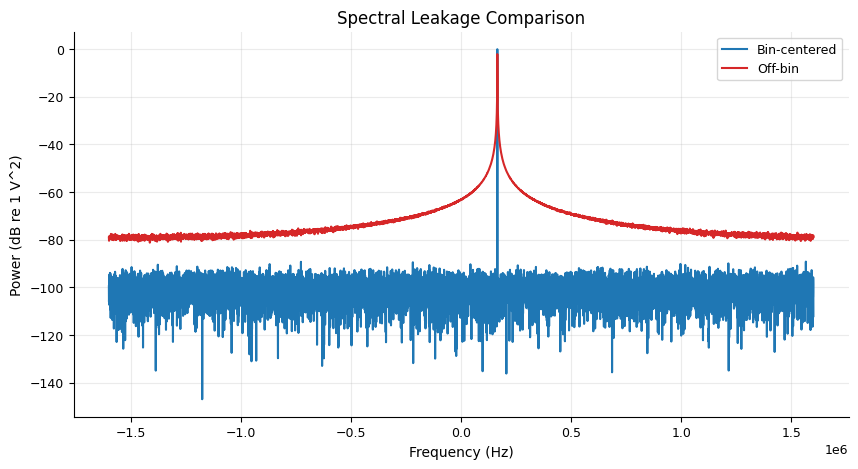

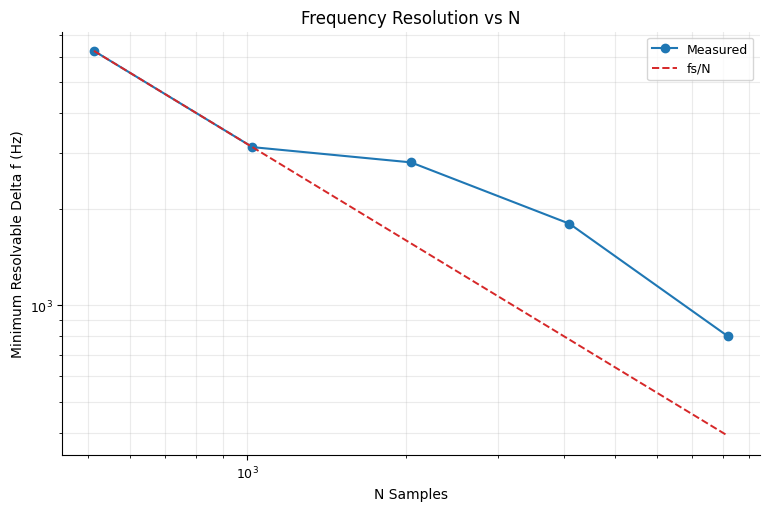

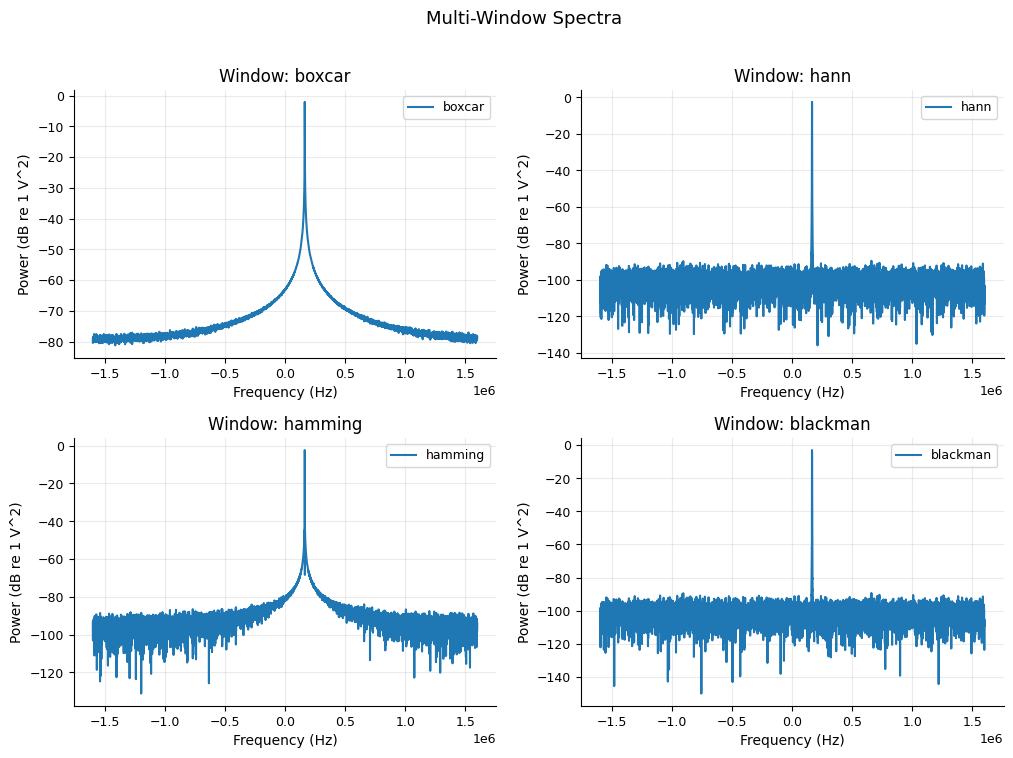

,n_samples,sample_rate_hz,delta_f_bin_hz,min_resolvable_delta_f_hz,resolution_ratio,tone_center_hz,n_delta_trials
0,512,3200000.0,6250.000,NaN,NaN,280000.0,12
1,1024,3200000.0,3125.000,NaN,NaN,280000.0,12
2,2048,3200000.0,1562.500,2800.0,1.792,280000.0,12
3,4096,3200000.0,781.250,1800.0,2.304,280000.0,12
4,8192,3200000.0,390.625,800.0,2.048,280000.0,12


In [15]:
# SIM_RUNNER: E4 Leakage/Resolution/Nyquist windows -> F7, F8, F9
fs_e4 = 3.2e6
n_e4 = 8192

leak_sim = simulate_leakage_experiment(
    sample_rate_hz=fs_e4,
    n_samples=n_e4,
    bin_index=420,
    bin_offset=0.37,
    amplitude_v=1.0,
    noise_std_v=0.001,
)

f7_builder = LeakageComparisonFigureBuilder()
fig_f7, _ = f7_builder.build(
    leak_sim.frequency_hz,
    leak_sim.bin_centered_power_v2,
    leak_sim.off_bin_power_v2,
    db=True,
)
save_figure(fig_f7, "F7_leakage_comparison_sim.png")

resolution_sim = simulate_resolution_sweep(
    sample_rate_hz=fs_e4,
    n_samples_values=np.array([512, 1024, 2048, 4096, 8192]),
    delta_f_hz_candidates=np.array([400, 600, 800, 1000, 1200, 1400, 1800, 2200, 2800, 3600, 4600, 5800], dtype=float),
    tone_center_hz=280_000.0,
    tone_amplitude_v=1.0,
    noise_std_v=0.005,
    min_peak_prominence_db=4.0,
    min_valley_depth_db=0.4,
)
resolution_table = resolution_sim.table.copy()
measured_delta_f = resolution_table["min_resolvable_delta_f_hz"].to_numpy(dtype=float)
measured_delta_f = np.where(np.isfinite(measured_delta_f), measured_delta_f, resolution_table["delta_f_bin_hz"].to_numpy(dtype=float))

f8_builder = ResolutionFigureBuilder()
fig_f8, _ = f8_builder.build(
    resolution_table["n_samples"].to_numpy(dtype=float),
    measured_delta_f,
    sample_rate_hz=resolution_table["sample_rate_hz"].to_numpy(dtype=float),
)
save_figure(fig_f8, "F8_resolution_vs_n_sim.png")

window_spectra: dict[str, tuple[np.ndarray, np.ndarray]] = {}
for label, window in {
    "boxcar": None,
    "hann": "hann",
    "hamming": "hamming",
    "blackman": "blackman",
}.items():
    freq_hz, power_win = power_spectrum(
        leak_sim.off_bin_voltage_v,
        sample_rate_hz=fs_e4,
        window=window,
        center=True,
        scaling="power",
    )
    window_spectra[label] = (freq_hz, power_win)

f9_builder = MultiWindowSpectrumFigureBuilder()
fig_f9, _ = f9_builder.build(window_spectra, ncols=2, db=True)
save_figure(fig_f9, "F9_multi_window_spectra_sim.png")
resolution_table


<!-- SIM_CAPTION:E4 -->
**Figure F7 (Simulation): Spectral leakage for bin-centered vs off-bin tone.** The off-bin tone spreads energy into sidelobes, while the bin-centered tone remains concentrated, demonstrating finite-record leakage behavior.

**Figure F8 (Simulation): Two-tone resolution versus sample count N.** Minimum resolvable tone spacing decreases as N increases, following the expected trend set by bin spacing (\(\Delta f \sim f_s/N\)).

**Figure F9 (Simulation): Multi-window spectra.** Comparing boxcar and tapered windows (Hann/Hamming/Blackman) shows the classic tradeoff between main-lobe width and sidelobe suppression across identical simulated data.


### E5. Noise Statistics, ACF, and Radiometer Equation

**Objective:** Test noise distribution assumptions and radiometer scaling; cross-check ACF/spectrum consistency.

**Physical Steps (bench):**
1. Connect noise source with anti-alias bandpass filtering and acquire long records.
2. Build histograms, mean/variance summaries, and averaged power spectra by blocks.
3. Compute ACF directly and via inverse-transform route.

**Simulation Steps (model):**
1. Generate Gaussian noise sequences with matched sample rate/bandwidth.
2. Replicate block averaging and fit `sigma` vs averaging factor.
3. Compare synthetic and measured ACF width and spectrum width relationships.

**Calibration and Diagnostics:**
- Terminated-input baseline before noise source connection.
- Stationarity checks across time slices (mean/variance drift).
- Log-log slope fit with uncertainty and goodness-of-fit.

**Data collected (run IDs):**  
**Primary figures/tables:** F10, F11, F12, T6  

**Analysis (processing and quantitative tests):**
- Distribution fit metrics (e.g., mean/variance consistency, normality checks).
- Radiometer-law slope and confidence interval extraction.

**Key quantitative results:**  

**Discussion (interpretation and model agreement):**
- Whether observed scaling supports statistical-noise expectations.
- How deviations map to non-stationarity or bandwidth limits.

**Limitations and next checks:**


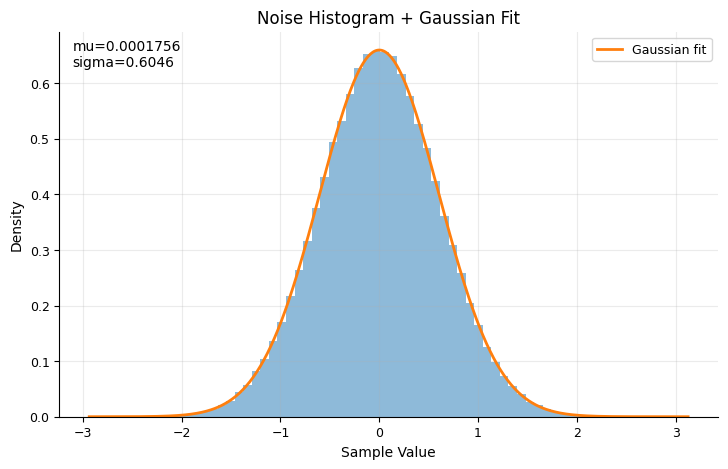

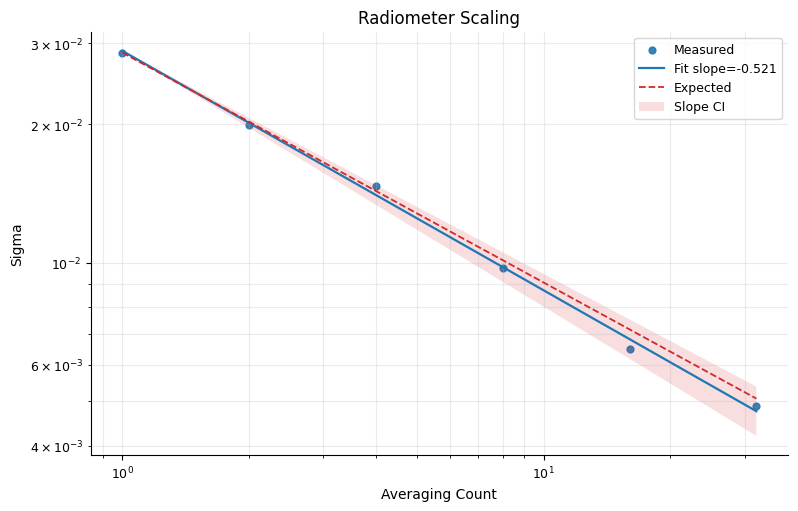

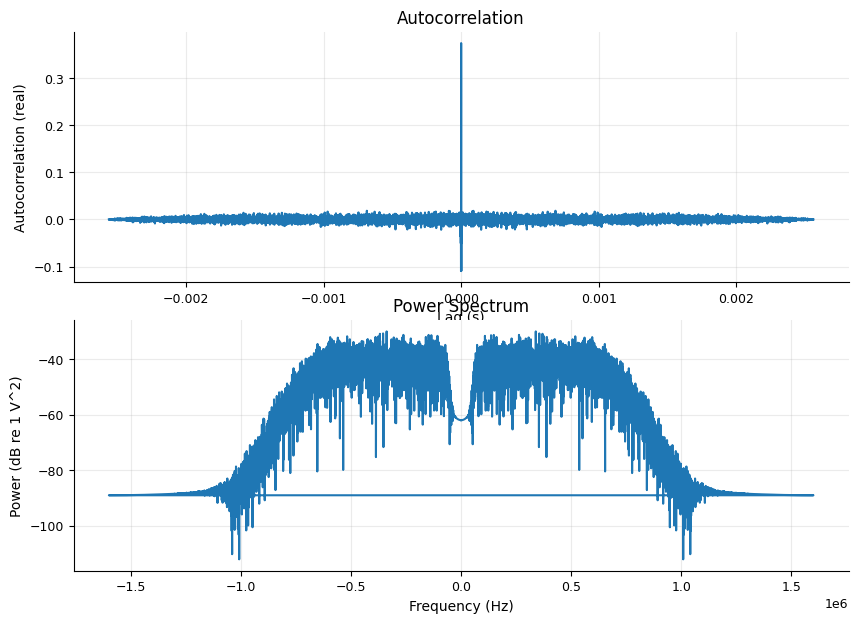

,n_avg,sigma_power,expected_sigma_power,sample_rate_hz,block_size,n_realizations
0,1,0.028659,0.028659,3200000.0,1024,256
1,2,0.019965,0.020265,3200000.0,1024,256
2,4,0.014723,0.014330,3200000.0,1024,256
3,8,0.009728,0.010133,3200000.0,1024,256
4,16,0.006495,0.007165,3200000.0,1024,256
5,32,0.004882,0.005066,3200000.0,1024,256


In [16]:
# SIM_RUNNER: E5 Noise/ACF/Radiometer -> F10, F11, F12
fs_e5 = 3.2e6

noise_blocks = simulate_noise_capture(
    sample_rate_hz=fs_e5,
    n_samples=4096,
    n_blocks=64,
    std_v=1.0,
    low_cut_hz=60_000.0,
    high_cut_hz=700_000.0,
    filter_order=4,
    squeeze=False,
    rng=RNG,
)

f10_builder = NoiseHistogramFigureBuilder()
fig_f10, _ = f10_builder.build(np.real(noise_blocks).ravel(), bins=70)
save_figure(fig_f10, "F10_noise_histogram_sim.png")

radiometer_sim = simulate_radiometer_experiment(
    sample_rate_hz=fs_e5,
    block_size=1024,
    n_avg_values=np.array([1, 2, 4, 8, 16, 32]),
    n_realizations=256,
    std_v=1.0,
    low_cut_hz=60_000.0,
    high_cut_hz=700_000.0,
    filter_order=4,
    rng=RNG,
)
fit = radiometer_fit(
    radiometer_sim.table["n_avg"].to_numpy(dtype=float),
    radiometer_sim.table["sigma_power"].to_numpy(dtype=float),
)

f11_builder = RadiometerFigureBuilder()
fig_f11, _ = f11_builder.build(
    radiometer_sim.table["n_avg"].to_numpy(dtype=float),
    radiometer_sim.table["sigma_power"].to_numpy(dtype=float),
    fit_result=fit,
)
save_figure(fig_f11, "F11_radiometer_scaling_sim.png")

acf_sim = simulate_acf_consistency(
    sample_rate_hz=fs_e5,
    n_samples=8192,
    std_v=1.0,
    low_cut_hz=60_000.0,
    high_cut_hz=700_000.0,
    filter_order=4,
    rng=RNG,
)

f12_builder = ACFSpectrumConsistencyFigureBuilder()
fig_f12, _ = f12_builder.build(
    acf_sim.lag_direct_s,
    acf_sim.autocorrelation_direct,
    acf_sim.frequency_hz,
    acf_sim.power_v2,
)
save_figure(fig_f12, "F12_acf_spectrum_consistency_sim.png")
radiometer_sim.table


<!-- SIM_CAPTION:E5 -->
**Figure F10 (Simulation): Noise histogram with Gaussian overlay.** Band-limited synthetic noise is statistically consistent with a Gaussian model over the displayed sample distribution.

**Figure F11 (Simulation): Radiometer scaling.** Block-averaged noise power variance decreases approximately as \(1/\sqrt{N_{avg}}\), and the fitted log-log slope is compared against the radiometer expectation.

**Figure F12 (Simulation): ACF and power-spectrum consistency.** Direct autocorrelation and transform-derived spectral structure are mutually consistent, supporting the analysis pipeline used for noise characterization.


#### E5 Physical Pipeline Integration (Raw -> Processed)

This block ingests `data/raw/e5.tar.gz`, writes E5 interim/processed artifacts, and updates physical F10/F11/F12 figures for the report.


,metric,value
0,raw_source,/Users/junruiting/GitHub/ugradio/labs/01/data/...
1,run_catalog_rows,10
2,qc_analysis_pass_rows,10
3,qc_recommended_pass_rows,0
4,analysis_noise_source,lab_noise_generator
5,analysis_runs,5
6,noise_stats_rows,5
7,radiometer_curve_rows,5
8,t2_rows,10
9,t6_rows,5


,noise_source,count
0,lab_noise_generator,5
1,terminated_input,5


,run_id,noise_source,sample_rate_hz,n_blocks,n_samples_per_block,n_total_samples,mean_counts,std_counts,rms_counts,median_counts,p05_counts,p95_counts,mean_block_rms_counts,qc_analysis_pass,qc_recommended_pass
0,e5_20260209T060850Z,lab_noise_generator,3200000.0,5,2048,10240,-1.511426,6.558255,6.729853,-2.0,-12.0,9.0,6.729467,True,False
1,e5_20260209T060918Z,lab_noise_generator,3200000.0,5,2048,10240,-1.460059,6.581067,6.740771,-2.0,-12.0,10.0,6.739879,True,False
2,e5_20260209T060931Z,lab_noise_generator,3200000.0,5,2048,10240,-1.392871,6.702665,6.845541,-1.0,-12.0,10.0,6.845391,True,False
3,e5_20260209T060947Z,lab_noise_generator,3200000.0,5,2048,10240,-1.369336,6.717124,6.854957,-1.0,-12.0,10.0,6.854797,True,False
4,e5_20260209T061000Z,lab_noise_generator,3200000.0,5,2048,10240,-1.583203,6.570711,6.758444,-2.0,-12.0,9.0,6.757783,True,False


,block_size,n_avg,sigma_power,fitted_slope,expected_slope,chi2_dof,expected_sigma_power,n_groups,total_segments,sample_rate_hz,num_runs_used,noise_source_filter,run_ids_json,fitted_intercept,r_squared,slope_ci_low,slope_ci_high
0,256,1,3.977051,-0.477659,-0.5,0.000981,3.977051,200,200,3200000.0,5,lab_noise_generator,"[""e5_20260209T060850Z"", ""e5_20260209T060918Z"",...",0.586139,0.985959,-0.582394,-0.372923
1,256,2,2.782147,-0.477659,-0.5,0.000981,2.812200,100,200,3200000.0,5,lab_noise_generator,"[""e5_20260209T060850Z"", ""e5_20260209T060918Z"",...",0.586139,0.985959,-0.582394,-0.372923
2,256,4,1.941200,-0.477659,-0.5,0.000981,1.988526,50,200,3200000.0,5,lab_noise_generator,"[""e5_20260209T060850Z"", ""e5_20260209T060918Z"",...",0.586139,0.985959,-0.582394,-0.372923
3,256,8,1.306088,-0.477659,-0.5,0.000981,1.406100,25,200,3200000.0,5,lab_noise_generator,"[""e5_20260209T060850Z"", ""e5_20260209T060918Z"",...",0.586139,0.985959,-0.582394,-0.372923
4,256,16,1.108707,-0.477659,-0.5,0.000981,0.994263,12,200,3200000.0,5,lab_noise_generator,"[""e5_20260209T060850Z"", ""e5_20260209T060918Z"",...",0.586139,0.985959,-0.582394,-0.372923


,n_avg,sigma_power,expected_sigma_power,n_groups,total_segments,block_size,sample_rate_hz,num_runs_used,noise_source_filter,run_ids_json
0,1,3.977051,3.977051,200,200,256,3200000.0,5,lab_noise_generator,"[""e5_20260209T060850Z"", ""e5_20260209T060918Z"",..."
1,2,2.782147,2.812200,100,200,256,3200000.0,5,lab_noise_generator,"[""e5_20260209T060850Z"", ""e5_20260209T060918Z"",..."
2,4,1.941200,1.988526,50,200,256,3200000.0,5,lab_noise_generator,"[""e5_20260209T060850Z"", ""e5_20260209T060918Z"",..."
3,8,1.306088,1.406100,25,200,256,3200000.0,5,lab_noise_generator,"[""e5_20260209T060850Z"", ""e5_20260209T060918Z"",..."
4,16,1.108707,0.994263,12,200,256,3200000.0,5,lab_noise_generator,"[""e5_20260209T060850Z"", ""e5_20260209T060918Z"",..."


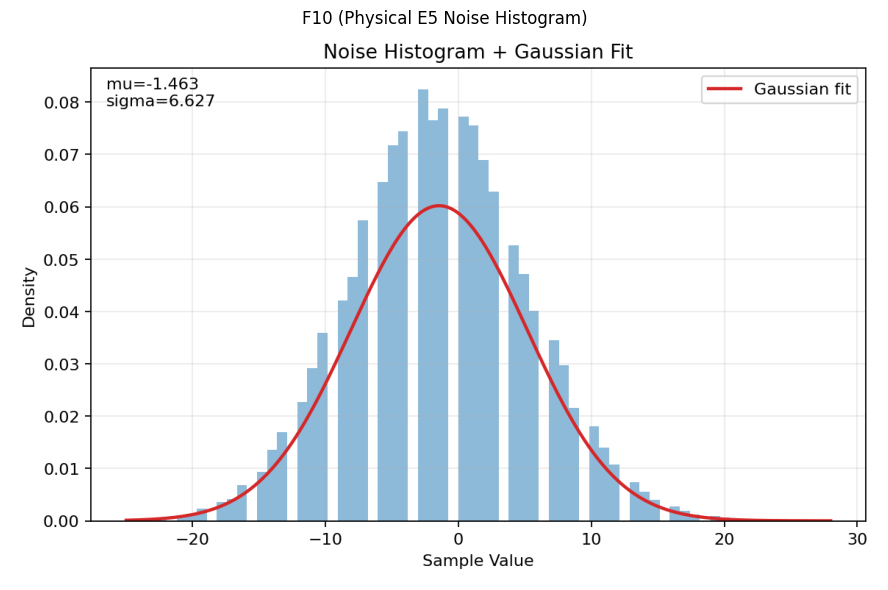

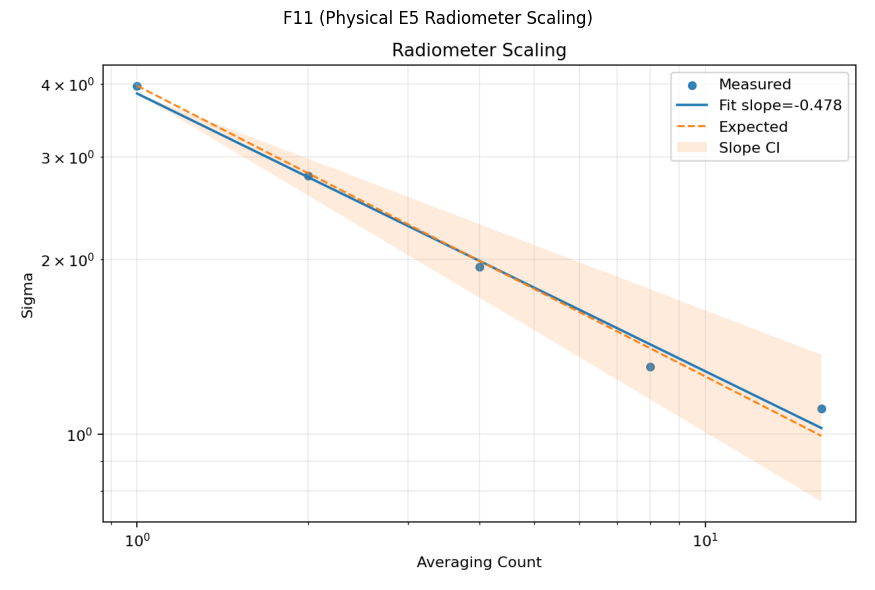

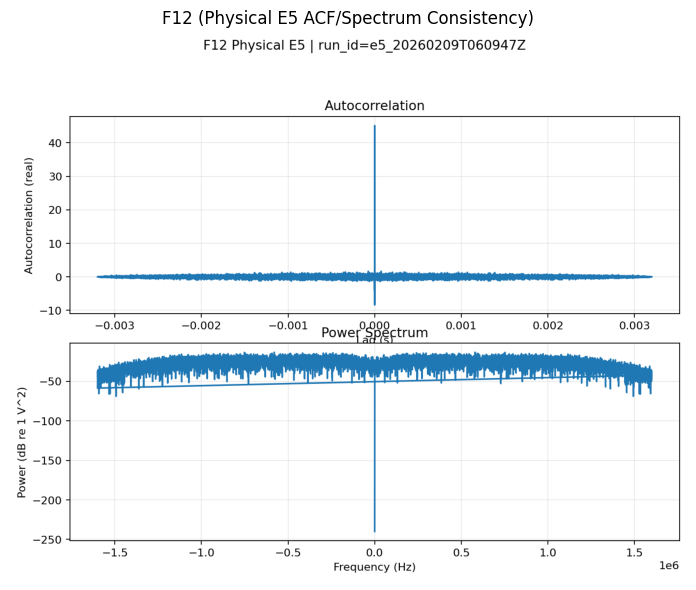

In [17]:
# PIPELINE_RUNNER: E5 physical raw -> processed integration
REBUILD_E5_PHYSICAL = False
E5_ANALYSIS_NOISE_SOURCE = "lab_noise_generator"
E5_RADIOMETER_BLOCK_SIZE = 256
E5_RADIOMETER_N_AVG = (1, 2, 4, 8, 16)

E5_RAW_SOURCE = LAB_DIR / DEFAULT_E5_RAW_SOURCE
E5_RUN_CATALOG_PATH = LAB_DIR / DEFAULT_E5_RUN_CATALOG_PATH
E5_QC_CATALOG_PATH = LAB_DIR / DEFAULT_E5_QC_CATALOG_PATH
E5_STATS_TABLE_PATH = LAB_DIR / DEFAULT_E5_STATS_TABLE_PATH
E5_CURVE_TABLE_PATH = LAB_DIR / DEFAULT_E5_CURVE_TABLE_PATH
E5_T2_TABLE_PATH = LAB_DIR / DEFAULT_E5_T2_TABLE_PATH
E5_T6_TABLE_PATH = LAB_DIR / DEFAULT_E5_T6_TABLE_PATH
E5_F10_PHYSICAL_PATH = LAB_DIR / DEFAULT_E5_F10_FIGURE_PATH
E5_F11_PHYSICAL_PATH = LAB_DIR / DEFAULT_E5_F11_FIGURE_PATH
E5_F12_PHYSICAL_PATH = LAB_DIR / DEFAULT_E5_F12_FIGURE_PATH

if not E5_RAW_SOURCE.exists():
    raise FileNotFoundError(f"E5 raw source not found: {E5_RAW_SOURCE}")

need_rebuild_e5 = REBUILD_E5_PHYSICAL or not (
    E5_RUN_CATALOG_PATH.exists()
    and E5_QC_CATALOG_PATH.exists()
    and E5_STATS_TABLE_PATH.exists()
    and E5_CURVE_TABLE_PATH.exists()
    and E5_T2_TABLE_PATH.exists()
    and E5_T6_TABLE_PATH.exists()
    and E5_F10_PHYSICAL_PATH.exists()
    and E5_F11_PHYSICAL_PATH.exists()
    and E5_F12_PHYSICAL_PATH.exists()
)

if need_rebuild_e5:
    e5_run_catalog = build_e5_run_catalog(E5_RAW_SOURCE)
    e5_qc_catalog = build_e5_qc_catalog(e5_run_catalog)
    e5_noise_stats = build_e5_noise_stats_table(
        e5_qc_catalog,
        use_qc_analysis_pass=True,
        noise_source_filter=E5_ANALYSIS_NOISE_SOURCE,
    )
    e5_radiometer_curve = build_e5_radiometer_curve_table(
        e5_qc_catalog,
        use_qc_analysis_pass=True,
        noise_source_filter=E5_ANALYSIS_NOISE_SOURCE,
        block_size=E5_RADIOMETER_BLOCK_SIZE,
        n_avg_values=E5_RADIOMETER_N_AVG,
    )
    e5_radiometer_fit = fit_e5_radiometer(e5_radiometer_curve)
    e5_t2_physical = build_e5_t2_table(e5_qc_catalog)
    e5_t6_physical = build_e5_t6_table(e5_radiometer_curve, fit_result=e5_radiometer_fit)

    write_dataframe_csv(e5_run_catalog, E5_RUN_CATALOG_PATH)
    write_dataframe_csv(e5_qc_catalog, E5_QC_CATALOG_PATH)
    write_dataframe_csv(e5_noise_stats, E5_STATS_TABLE_PATH)
    write_dataframe_csv(e5_radiometer_curve, E5_CURVE_TABLE_PATH)
    write_table_manifest_csv(e5_t2_physical, E5_T2_TABLE_PATH)
    write_table_manifest_csv(e5_t6_physical, E5_T6_TABLE_PATH)

    write_e5_noise_histogram_figure(
        e5_qc_catalog,
        E5_F10_PHYSICAL_PATH,
        use_qc_analysis_pass=True,
        noise_source_filter=E5_ANALYSIS_NOISE_SOURCE,
    )
    write_e5_radiometer_figure(
        e5_radiometer_curve,
        E5_F11_PHYSICAL_PATH,
        fit_result=e5_radiometer_fit,
    )
    write_e5_acf_consistency_figure(
        e5_qc_catalog,
        E5_F12_PHYSICAL_PATH,
        use_qc_analysis_pass=True,
        noise_source_filter=E5_ANALYSIS_NOISE_SOURCE,
    )
else:
    e5_run_catalog = pd.read_csv(E5_RUN_CATALOG_PATH)
    e5_qc_catalog = pd.read_csv(E5_QC_CATALOG_PATH)
    e5_noise_stats = pd.read_csv(E5_STATS_TABLE_PATH)
    e5_radiometer_curve = pd.read_csv(E5_CURVE_TABLE_PATH)
    e5_t2_physical = pd.read_csv(E5_T2_TABLE_PATH)
    e5_t6_physical = pd.read_csv(E5_T6_TABLE_PATH)
    e5_radiometer_fit = fit_e5_radiometer(e5_radiometer_curve)

e5_analysis_runs = select_e5_analysis_runs(
    e5_qc_catalog,
    use_qc_analysis_pass=True,
    noise_source_filter=E5_ANALYSIS_NOISE_SOURCE,
)

noise_source_counts = (
    e5_run_catalog["noise_source"]
    .astype(str)
    .value_counts(dropna=False)
    .rename_axis("noise_source")
    .reset_index(name="count")
    if "noise_source" in e5_run_catalog.columns
    else pd.DataFrame(columns=["noise_source", "count"])
)

summary_e5_physical = pd.DataFrame(
    {
        "metric": [
            "raw_source",
            "run_catalog_rows",
            "qc_analysis_pass_rows",
            "qc_recommended_pass_rows",
            "analysis_noise_source",
            "analysis_runs",
            "noise_stats_rows",
            "radiometer_curve_rows",
            "t2_rows",
            "t6_rows",
            "radiometer_slope",
            "radiometer_expected_slope",
            "f10_figure_path",
            "f11_figure_path",
            "f12_figure_path",
            "rebuild_performed",
        ],
        "value": [
            str(E5_RAW_SOURCE),
            len(e5_run_catalog),
            int(e5_qc_catalog["qc_analysis_pass"].fillna(False).sum()) if "qc_analysis_pass" in e5_qc_catalog.columns else np.nan,
            int(e5_qc_catalog["qc_recommended_pass"].fillna(False).sum()) if "qc_recommended_pass" in e5_qc_catalog.columns else np.nan,
            E5_ANALYSIS_NOISE_SOURCE,
            len(e5_analysis_runs),
            len(e5_noise_stats),
            len(e5_radiometer_curve),
            len(e5_t2_physical),
            len(e5_t6_physical),
            float(e5_radiometer_fit["slope"]),
            float(e5_radiometer_fit["expected_slope"]),
            str(E5_F10_PHYSICAL_PATH),
            str(E5_F11_PHYSICAL_PATH),
            str(E5_F12_PHYSICAL_PATH),
            bool(need_rebuild_e5),
        ],
    }
)

display(summary_e5_physical)
display(noise_source_counts)
display(e5_noise_stats.head())
display(e5_t6_physical)
display(e5_radiometer_curve)

for figure_path, title in [
    (E5_F10_PHYSICAL_PATH, "F10 (Physical E5 Noise Histogram)"),
    (E5_F11_PHYSICAL_PATH, "F11 (Physical E5 Radiometer Scaling)"),
    (E5_F12_PHYSICAL_PATH, "F12 (Physical E5 ACF/Spectrum Consistency)"),
]:
    image = plt.imread(figure_path)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image)
    ax.set_title(title)
    ax.axis("off")
    fig.tight_layout()
    display(fig)
    plt.close(fig)

generated_figure_labels.append(str(E5_F10_PHYSICAL_PATH))
generated_figure_labels.append(str(E5_F11_PHYSICAL_PATH))
generated_figure_labels.append(str(E5_F12_PHYSICAL_PATH))


<!-- PHYS_CAPTION:E5 -->\n**Figure F10/F11/F12 (Physical): E5 noise distribution, radiometer scaling, and ACF/spectrum consistency.** The notebook pipeline ingests `data/raw/e5.tar.gz`, builds normalized run/QC catalogs, computes noise-stat and radiometer-curve tables, writes processed T2/T6 outputs, and renders canonical physical figures to `report/figures/F10_noise_histogram_physical.png`, `report/figures/F11_radiometer_scaling_physical.png`, and `report/figures/F12_acf_spectrum_consistency_physical.png`.


### E6. DSB Mixer Operation and Intermodulation

**Objective:** Verify DSB sum/difference behavior and map non-ideal intermodulation products.

**Physical Steps (bench):**
1. Configure DSB mixer with planned LO/RF frequencies and power levels.
2. Acquire spectra for `f_RF = f_LO + delta f` and `f_RF = f_LO - delta f` cases.
3. Record wide dynamic-range spectra for spur mapping.

**Simulation Steps (model):**
1. Model ideal multiplication and expected product frequencies.
2. Add low-order nonlinear terms to predict intermod spur families.
3. Match observed spur locations against modeled expectations.

**Calibration and Diagnostics:**
- Verify generator powers and impedance assumptions before each run.
- Check for overdrive by stepping input level and tracking spur growth.
- Maintain a line-by-line expected vs observed frequency table.

**Data collected (run IDs):**  
**Primary figures/tables:** F13, F14, F15, T7  

**Analysis (processing and quantitative tests):**
- Line-identification workflow and tolerance criteria.
- Spur level extraction and ordering by amplitude.

**Key quantitative results:**  

**Discussion (interpretation and model agreement):**
- Which lines are ideal products vs non-ideal intermodulation.
- Implications for downstream spectral interpretation.

**Limitations and next checks:**


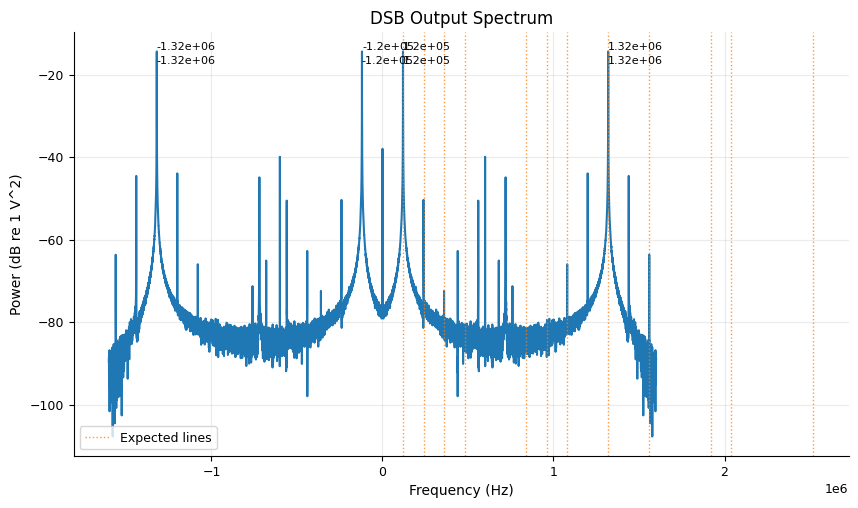

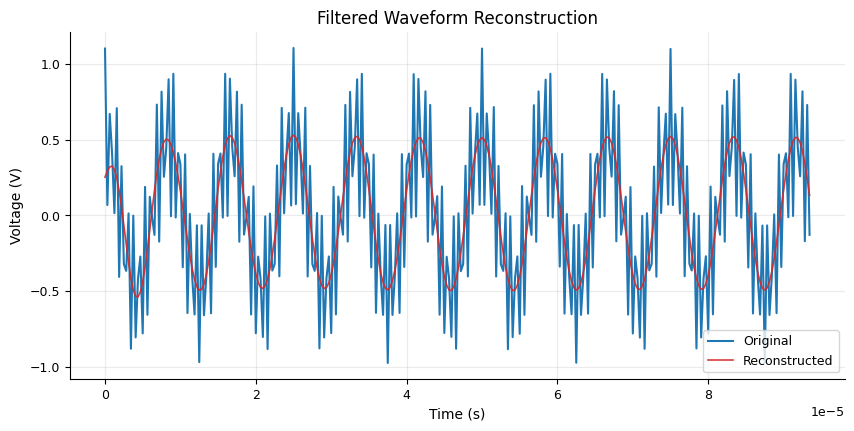

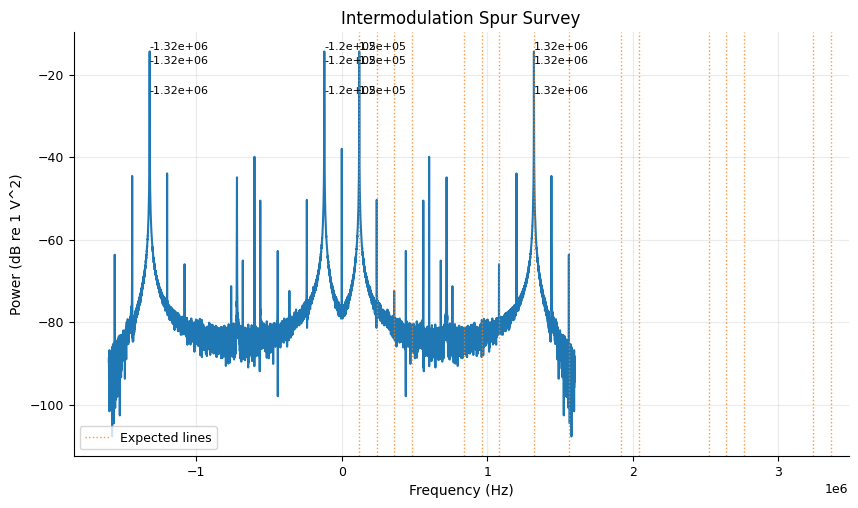

,config,f_lo_hz,f_rf_hz,expected_line_hz,observed_line_hz,level_db,interpretation,family,formula,line_id
0,dsb_external,600000.0,720000.0,120000.0,1.199219e+05,-14.389721,expected_dsb_product,dsb_primary,|f_rf - f_lo|,L000
1,dsb_external,600000.0,720000.0,120000.0,NaN,NaN,missing_expected_line,intermod,|1*f_lo - 1*f_rf|,L001
2,dsb_external,600000.0,720000.0,240000.0,2.400391e+05,-50.377648,intermod_spur,intermod,|2*f_lo - 2*f_rf|,L002
3,dsb_external,600000.0,720000.0,360000.0,3.599609e+05,-72.452568,intermod_spur,intermod,|3*f_lo - 2*f_rf|,L003
4,dsb_external,600000.0,720000.0,360000.0,NaN,NaN,missing_expected_line,intermod,|3*f_lo - 3*f_rf|,L004
5,dsb_external,600000.0,720000.0,480000.0,NaN,NaN,missing_expected_line,intermod,|2*f_lo - 1*f_rf|,L005
6,dsb_external,600000.0,720000.0,840000.0,NaN,NaN,missing_expected_line,intermod,|1*f_lo - 2*f_rf|,L006
7,dsb_external,600000.0,720000.0,960000.0,NaN,NaN,missing_expected_line,intermod,|2*f_lo - 3*f_rf|,L007
8,dsb_external,600000.0,720000.0,1080000.0,1.080078e+06,-65.978116,intermod_spur,intermod,|3*f_lo - 1*f_rf|,L008
9,dsb_external,600000.0,720000.0,1320000.0,1.319922e+06,-14.386820,expected_dsb_product,dsb_primary,f_rf + f_lo,L009


In [18]:
# SIM_RUNNER: E6 DSB/Intermod -> F13, F14, F15
fs_e6 = 3.2e6
n_e6 = 16384
f_lo_e6 = 600_000.0
f_rf_e6 = 720_000.0

spur_sim = simulate_dsb_spur_survey(
    f_lo_hz=f_lo_e6,
    f_rf_hz=f_rf_e6,
    sample_rate_hz=fs_e6,
    n_samples=n_e6,
    config="dsb_external",
    orders=3,
    tolerance_hz=600.0,
    n_observed_lines=20,
    min_line_spacing_hz=20_000.0,
    nonlinear_kwargs={
        "linear_gain": 1.0,
        "second_order_gain": 0.05,
        "third_order_gain": 0.015,
        "lo_leakage_gain": 0.02,
        "rf_leakage_gain": 0.015,
        "noise_std_v": 0.002,
    },
    rng=RNG,
)

expected_lines = np.unique(
    spur_sim.catalog["expected_line_hz"].dropna().to_numpy(dtype=float)
)
expected_lines = expected_lines[np.isfinite(expected_lines)]

f13_builder = DSBOutputSpectrumFigureBuilder()
fig_f13, _ = f13_builder.build(
    spur_sim.frequency_hz,
    spur_sim.power_v2,
    expected_lines_hz=expected_lines[:12],
    annotate_top_n=8,
)
save_figure(fig_f13, "F13_dsb_output_spectrum_sim.png")

# Frequency-domain low-pass filtering and inverse transform for F14.
spectrum = np.fft.fft(spur_sim.voltage_v)
frequency = np.fft.fftfreq(spur_sim.voltage_v.size, d=1.0 / fs_e6)
mask = np.abs(frequency) <= 220_000.0
reconstructed = np.fft.ifft(spectrum * mask).real
time_s = np.arange(spur_sim.voltage_v.size, dtype=float) / fs_e6

f14_builder = FilteredWaveformFigureBuilder()
fig_f14, _ = f14_builder.build(
    time_s,
    spur_sim.voltage_v,
    reconstructed,
    sample_slice=TIME_DOMAIN_SLICE,
)
save_figure(fig_f14, "F14_filtered_waveform_sim.png")

f15_builder = SpurSurveyFigureBuilder()
fig_f15, _ = f15_builder.build(
    spur_sim.frequency_hz,
    spur_sim.power_v2,
    expected_lines_hz=expected_lines[:16],
    annotate_top_n=12,
)
save_figure(fig_f15, "F15_spur_survey_sim.png")
spur_sim.catalog.head(12)


<!-- SIM_CAPTION:E6 -->
**Figure F13 (Simulation): DSB mixer output spectrum.** Expected sum/difference product lines from the synthetic LO/RF pair appear at predicted frequencies, with annotations marking dominant components.

**Figure F14 (Simulation): Inverse-transformed filtered waveform.** Frequency-domain low-pass selection followed by inverse transform isolates beat-scale structure in time domain, demonstrating reconstruction workflow from spectral filtering.

**Figure F15 (Simulation): Intermodulation spur survey.** Nonlinear mixer terms generate additional spur families beyond ideal products, and the wide dynamic-range spectrum captures their relative placement and prominence.


### E7. SSB Mixer, Reversion to DSB, and R820T Comparison

**Objective:** Demonstrate sideband discrimination with SSB IQ phasing, then compare with DSB and internal SDR mixing.

**Physical Steps (bench):**
1. Build SSB chain with quadrature LO phase shift; acquire IQ outputs for upper/lower sidebands.
2. Reconfigure to DSB (short-cable/zero-phase condition) and repeat captures.
3. Acquire comparable data using the SDR internal R820T heterodyne path.

**Simulation Steps (model):**
1. Simulate IQ phasor evolution for positive/negative `delta f` sidebands.
2. Simulate DSB reversion and loss of sideband sign discrimination.
3. Compare modeled IQ/spectral signatures against external and R820T measurements.

**Calibration and Diagnostics:**
- Scope-verify I/Q phase relationships before long capture runs.
- Cable-delay sanity check using expected phase shift at LO frequency.
- Keep one unchanged reference tone across all configurations.

**Data collected (run IDs):**  
**Primary figures/tables:** F16, F17, F18, T7  

**Analysis (processing and quantitative tests):**
- IQ phase extraction method and sign-discrimination criteria.
- Quantitative comparison metrics: external SSB vs reverted DSB vs R820T.

**Key quantitative results:**  

**Discussion (interpretation and model agreement):**
- Evidence for/against sideband discrimination in each configuration.
- Practical significance of SSB behavior for heterodyne systems.

**Limitations and next checks:**


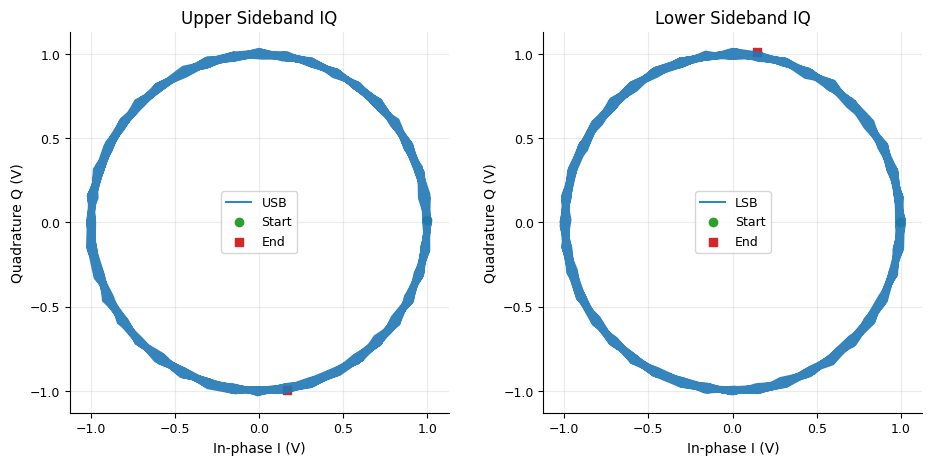

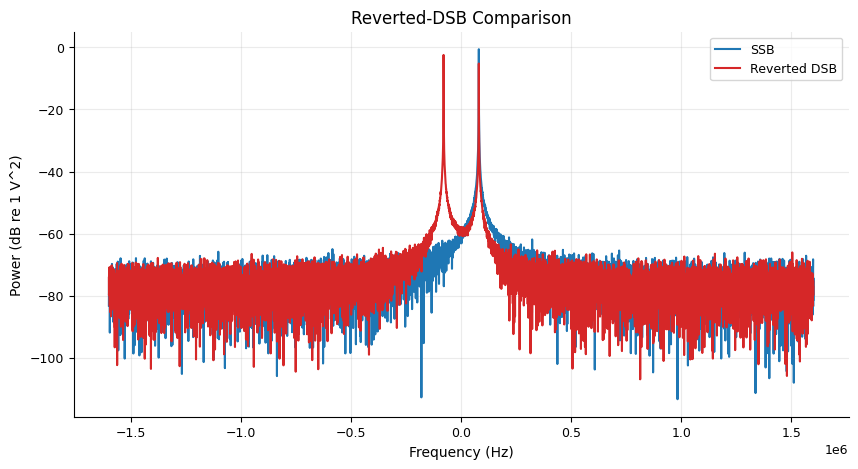

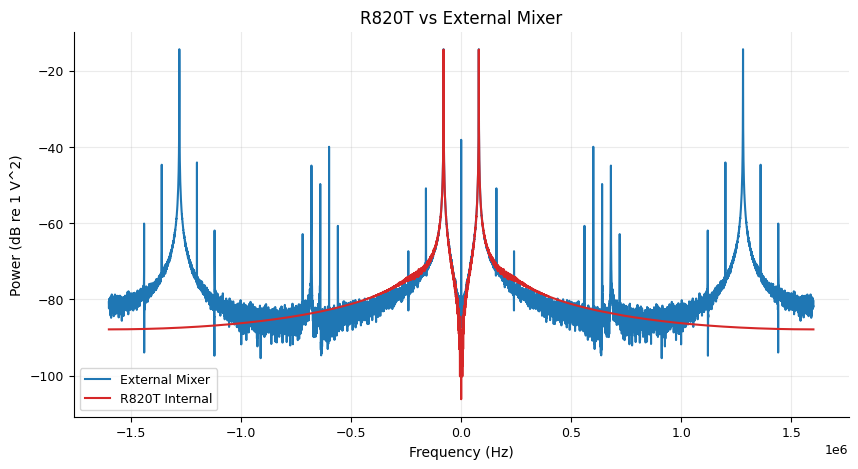

In [19]:
# SIM_RUNNER: E7 SSB/Reverted DSB/R820T -> F16, F17, F18
fs_e7 = 3.2e6
n_e7 = 8192
delta_f = 80_000.0

i_usb, q_usb = simulate_ssb_iq(
    delta_f_hz=delta_f,
    sample_rate_hz=fs_e7,
    n_samples=n_e7,
    sideband="upper",
    amplitude_v=1.0,
    noise_std_v=0.01,
    rng=RNG,
)
i_lsb, q_lsb = simulate_ssb_iq(
    delta_f_hz=delta_f,
    sample_rate_hz=fs_e7,
    n_samples=n_e7,
    sideband="lower",
    amplitude_v=1.0,
    noise_std_v=0.01,
    rng=RNG,
)

f16_builder = SSBIQBehaviorFigureBuilder()
fig_f16, _ = f16_builder.build(i_usb, q_usb, i_lsb, q_lsb)
save_figure(fig_f16, "F16_ssb_iq_behavior_sim.png")

z_ssb = i_usb + 1j * q_usb
i_dsb, q_dsb = simulate_reverted_dsb_iq(
    delta_f_hz=delta_f,
    sample_rate_hz=fs_e7,
    n_samples=n_e7,
    amplitude_v=1.0,
    phase_mismatch_rad=np.pi / 10.0,
    noise_std_v=0.01,
    rng=RNG,
)
z_dsb = i_dsb + 1j * q_dsb

frequency_ssb, power_ssb = power_spectrum(z_ssb, sample_rate_hz=fs_e7, scaling="power", center=True)
frequency_dsb, power_dsb = power_spectrum(z_dsb, sample_rate_hz=fs_e7, scaling="power", center=True)
if not np.allclose(frequency_ssb, frequency_dsb):
    raise RuntimeError("Frequency grids differ between SSB and reverted DSB simulation.")

f17_builder = RevertedDSBComparisonFigureBuilder()
fig_f17, _ = f17_builder.build(frequency_ssb, power_ssb, power_dsb, db=True)
save_figure(fig_f17, "F17_reverted_dsb_comparison_sim.png")

r820t = simulate_r820t_vs_external(
    f_lo_hz=600_000.0,
    f_rf_hz=680_000.0,
    sample_rate_hz=fs_e7,
    n_samples=16384,
    external_nonlinear_kwargs={
        "linear_gain": 1.0,
        "second_order_gain": 0.05,
        "third_order_gain": 0.02,
        "lo_leakage_gain": 0.02,
        "rf_leakage_gain": 0.015,
        "noise_std_v": 0.002,
    },
    rng=RNG,
)

f18_builder = R820TComparisonFigureBuilder()
fig_f18, _ = f18_builder.build(
    r820t["frequency_hz"],
    r820t["external_power_v2"],
    r820t["r820t_power_v2"],
    db=True,
)
save_figure(fig_f18, "F18_r820t_vs_external_sim.png")


<!-- SIM_CAPTION:E7 -->
**Figure F16 (Simulation): SSB IQ phase behavior (USB vs LSB).** Upper and lower sidebands exhibit mirrored quadrature trajectories, demonstrating sign-sensitive phase evolution in an idealized SSB model.

**Figure F17 (Simulation): Reverted-DSB comparison.** Reversion toward DSB-like behavior reduces sideband-sign discrimination, visible as a less selective spectral comparison relative to SSB.

**Figure F18 (Simulation): R820T-style internal path vs external mixer.** Side-by-side simulated spectra relate discrete external mixing behavior to an internal heterodyne-like chain with different filtering/nonlinearity signatures.


In [20]:
# SIM_RUNNER: Summary of generated figure files
for label in generated_figure_labels:
    print(label)

print(f"Total generated figures: {len(generated_figure_labels)}")


F3_time_domain_good_vs_bad_sim.png
F2_alias_map_sim.png
/Users/junruiting/GitHub/ugradio/labs/01/report/figures/F2_alias_map_physical.png
F4_bandpass_curves_sim.png
/Users/junruiting/GitHub/ugradio/labs/01/report/figures/F4_bandpass_curves_physical.png
F5_complex_voltage_components_sim.png
F6_voltage_vs_power_sim.png
/Users/junruiting/GitHub/ugradio/labs/01/report/figures/F5_complex_voltage_components_physical.png
/Users/junruiting/GitHub/ugradio/labs/01/report/figures/F6_voltage_vs_power_physical.png
F7_leakage_comparison_sim.png
F8_resolution_vs_n_sim.png
F9_multi_window_spectra_sim.png
F10_noise_histogram_sim.png
F11_radiometer_scaling_sim.png
F12_acf_spectrum_consistency_sim.png
/Users/junruiting/GitHub/ugradio/labs/01/report/figures/F10_noise_histogram_physical.png
/Users/junruiting/GitHub/ugradio/labs/01/report/figures/F11_radiometer_scaling_physical.png
/Users/junruiting/GitHub/ugradio/labs/01/report/figures/F12_acf_spectrum_consistency_physical.png
F13_dsb_output_spectrum_sim.p

## 10. Discussion

- Synthesize what held up across physical measurements and simulations.
- Identify disagreements between model and experiment.
- Attribute discrepancies to likely causes (instrument limits, calibration drift, model assumptions, analysis choices).
- Explicitly state confidence for each section-2 goal.


## 11. Conclusion

- Concise statement of major validated findings.
- Which goals were fully met, partially met, or deferred.
- One paragraph on why DSB/SSB and SDR spectral analysis matter for future labs.


## 12. Reproducibility and Software Appendix

- Package install command and version.
- Repository link and commit hash used for the report.
- Unit tests executed and pass/fail summary.
- Data provenance summary (raw -> processed -> figures/tables).
- Any manual interventions or notebook-only steps explicitly documented.
- E1 physical pipeline command: `PYTHONPATH=src /Users/junruiting/GitHub/ugradio/.venv/bin/python3 scripts/analyze/run_e1_pipeline.py --raw-source data/raw/e1.tar.gz`
- E2 physical pipeline command: `PYTHONPATH=src /Users/junruiting/GitHub/ugradio/.venv/bin/python3 scripts/analyze/run_e2_pipeline.py --raw-source data/raw/e2.tar.gz`
- E3 physical pipeline command: `PYTHONPATH=src /Users/junruiting/GitHub/ugradio/.venv/bin/python3 scripts/analyze/run_e3_pipeline.py --raw-source data/raw/e3.tar.gz`
- E5 physical pipeline command: `PYTHONPATH=src /Users/junruiting/GitHub/ugradio/.venv/bin/python3 scripts/analyze/run_e5_pipeline.py --raw-source data/raw/e5.tar.gz`


## 13. References

Use consistent citation format. Include:
- `lab_mixers/allmixers.tex`
- External references for equations/models/software behavior (if used)
- Any package or documentation sources beyond the manual


In [21]:
# Optional: helper placeholders for final write-up bookkeeping
REPORT_STATUS = {
    "abstract": "not started",
    "introduction": "not started",
    "theory": "not started",
    "methods": "not started",
    "results": "not started",
    "discussion": "not started",
    "conclusion": "not started",
}

REPORT_STATUS


{'abstract': 'not started',
 'introduction': 'not started',
 'theory': 'not started',
 'methods': 'not started',
 'results': 'not started',
 'discussion': 'not started',
 'conclusion': 'not started'}